# AAC Queries

## Setup and Configuration

First, we'll import required libraries and configure our environment for analysis.

In [1]:
!pip install duckdb pandas matplotlib seaborn wordcloud folium -q 

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
import json
from datetime import datetime

# Create a DuckDB connection with 16 threads for optimal performance
con = duckdb.connect(database=':memory:')
con.execute("PRAGMA threads=16")

print("DuckDB configuration complete with 16 threads")


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
DuckDB configuration complete with 16 threads


# Airiti Books Analysis

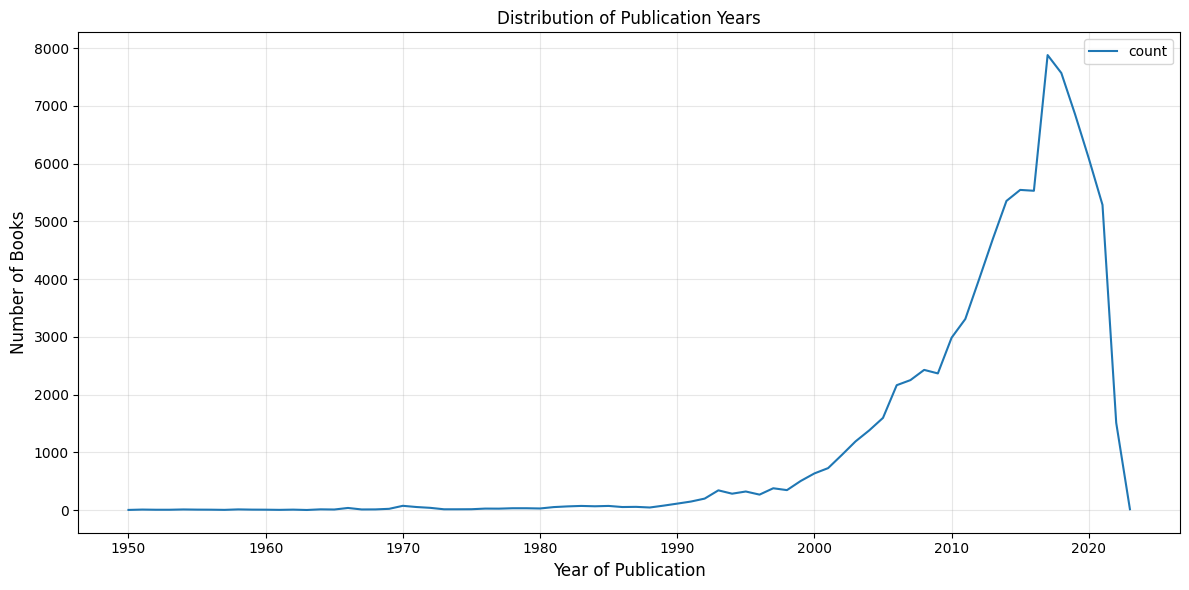

In [13]:
# Books publication analysis by year with cast for publish_year
query = """
SELECT 
    TRY_CAST(metadata_year AS INTEGER) AS publish_year,
    COUNT(*) AS count
FROM read_parquet('/data/aacF/aac_airitibooks_records*.parquet')
WHERE TRY_CAST(metadata_year AS INTEGER) IS NOT NULL
GROUP BY publish_year
HAVING publish_year BETWEEN 1900 AND 2025
ORDER BY publish_year;
"""

result = con.execute(query).fetchdf()

# Visualization of publication year distribution
result.plot(x='publish_year', y='count', kind='line', figsize=(12, 6), title="Distribution of Publication Years")
plt.xlabel('Year of Publication', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Analysis of 27913 books with page count information:

Statistical Summary of Page Counts:


<Figure size 1400x1000 with 0 Axes>

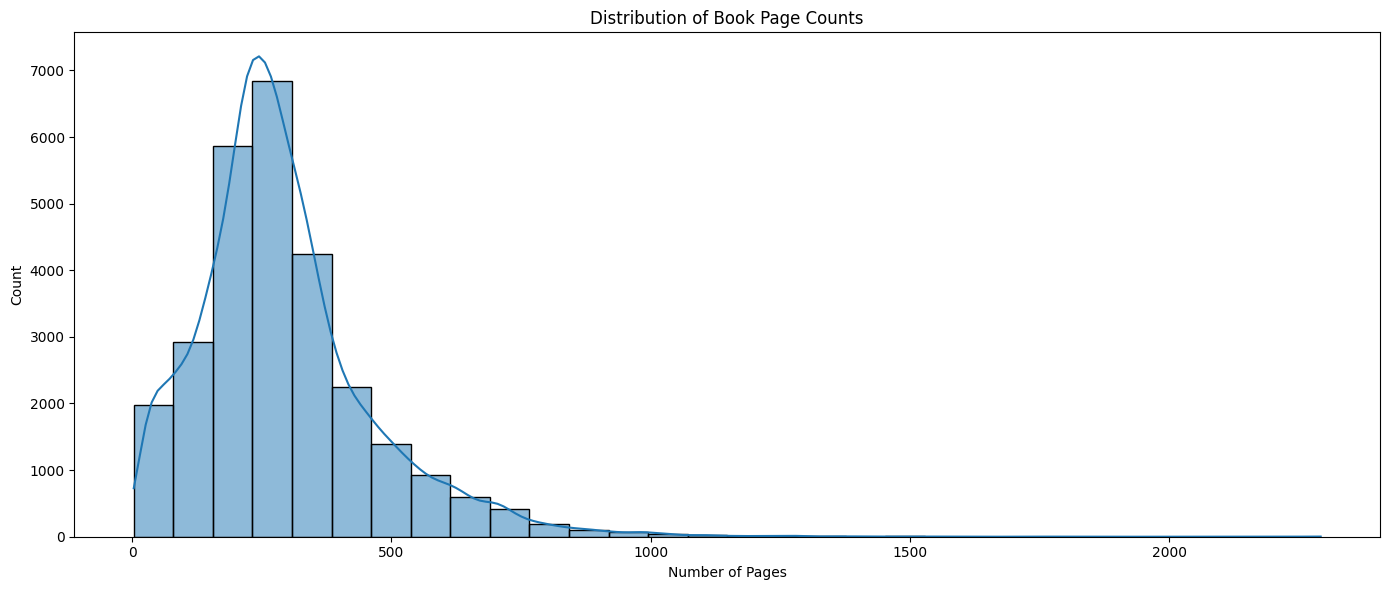

In [11]:
# Analysis of bookmark data and page counts
query = """
SELECT 
    metadata_bookname AS title,
    metadata_year AS publication_year,
    metadata_authors_0__name AS primary_author,
    metadata_isbn AS isbn,
    CAST(JSON_EXTRACT_STRING(metadata_bookmark_json, '$.PageCount') AS INT) AS page_count,
    CASE 
        WHEN JSON_EXTRACT_STRING(metadata_bookmark_json, '$.direction') = 'vertical' THEN 'Vertical'
        WHEN JSON_EXTRACT_STRING(metadata_bookmark_json, '$.direction') = 'horizontal' THEN 'Horizontal'
        ELSE 'Unknown'
    END AS reading_direction
FROM read_parquet('/data/aacF/aac_airitibooks_records*.parquet')
WHERE JSON_EXTRACT_STRING(metadata_bookmark_json, '$.PageCount') IS NOT NULL
ORDER BY page_count DESC
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} books with page count information:")
result.head(10)

# Statistical summary of page counts
page_stats = result['page_count'].describe()
print("\nStatistical Summary of Page Counts:")
page_stats

# Visualization of page counts
plt.figure(figsize=(14, 10))

# Visualization of page counts (just the distribution plot)
plt.figure(figsize=(14, 6))
sns.histplot(data=result, x='page_count', bins=30, kde=True)
plt.title('Distribution of Book Page Counts', fontsize=12)
plt.xlabel('Number of Pages', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()
plt.show()



# Bloomsbury Analysis

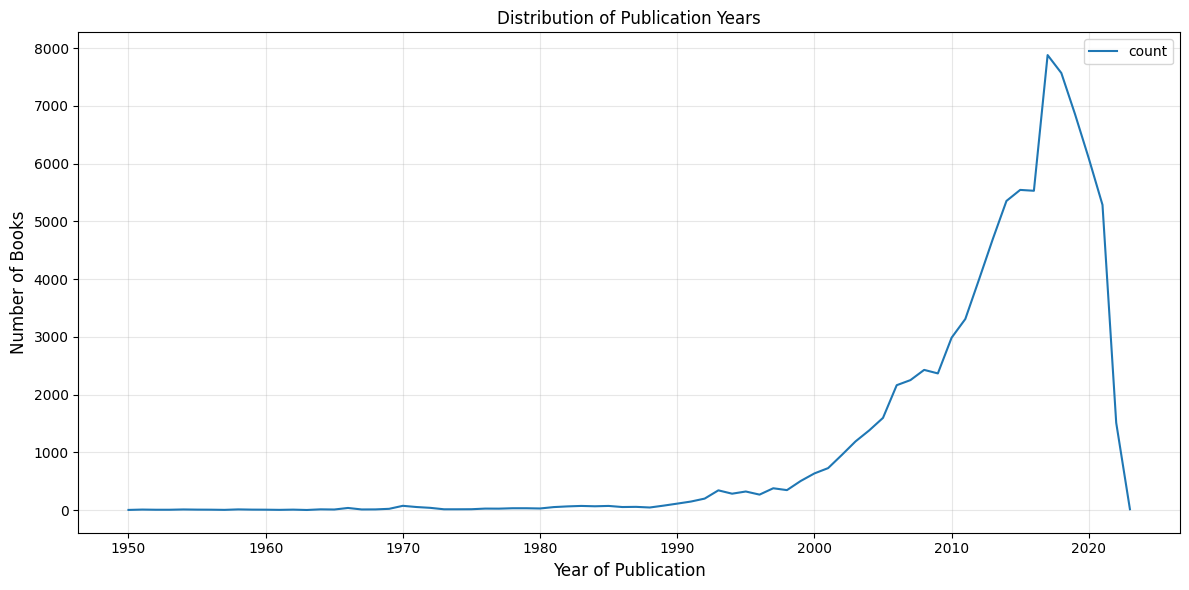

In [19]:
# Books publication analysis by year with cast for publish_year
query = """
SELECT 
    TRY_CAST(metadata_year AS INTEGER) AS publish_year,
    COUNT(*) AS count
FROM read_parquet('/data/aacF/aac_airitibooks_records*.parquet')
WHERE TRY_CAST(metadata_year AS INTEGER) IS NOT NULL
GROUP BY publish_year
HAVING publish_year BETWEEN 1900 AND 2025
ORDER BY publish_year;
"""

# Fetching the data
result = con.execute(query).fetchdf()

# Visualization of publication year distribution
result.plot(x='publish_year', y='count', kind='line', figsize=(12, 6), title="Distribution of Publication Years")
plt.xlabel('Year of Publication', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Analysis of 33531 Bloomsbury records with format information:


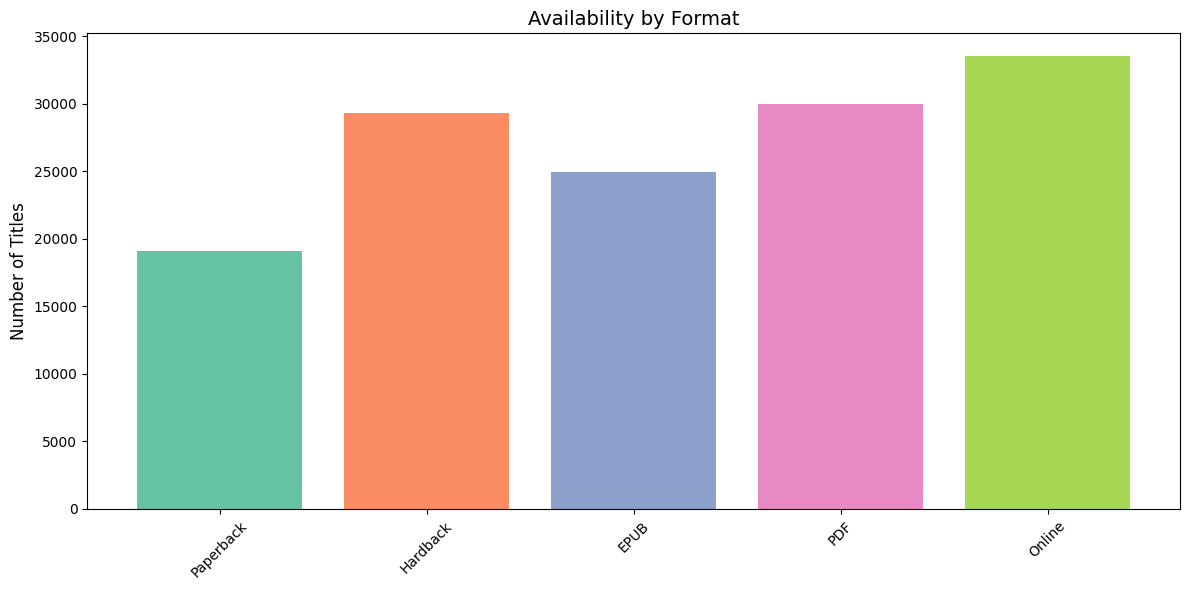

In [24]:
# ISBN Analysis and Collection Types
query = """
SELECT 
    metadata_Title AS title,
    "metadata_Collection Title" AS collection_title, 
    "metadata_Collection Type" AS collection_type, 
    metadata_Series AS series,
    "metadata_PB ISBN" AS paperback_isbn,  
    "metadata_HB ISBN" AS hardback_isbn,  
    "metadata_EPUB ISBN" AS epub_isbn, 
    "metadata_PDF EBOOK ISBN" AS pdf_isbn, 
    "metadata_ONLINE ISBN" AS online_isbn, 
    "metadata_Open Access" AS open_access,
    metadata_Status AS status
FROM read_parquet('/data/aacF/aac_bloomsbury_records*.parquet')
"""

# Fetching the data
result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} Bloomsbury records with format information:")
result.head(5)

# Create format availability columns
result['has_paperback'] = result['paperback_isbn'].notnull() & (result['paperback_isbn'] != '')
result['has_hardback'] = result['hardback_isbn'].notnull() & (result['hardback_isbn'] != '')
result['has_epub'] = result['epub_isbn'].notnull() & (result['epub_isbn'] != '')
result['has_pdf'] = result['pdf_isbn'].notnull() & (result['pdf_isbn'] != '')
result['has_online'] = result['online_isbn'].notnull() & (result['online_isbn'] != '')

# Visualization: Only one type of visualization (here, format availability)
plt.figure(figsize=(12, 6))

# Format distribution
format_counts = [
    result['has_paperback'].sum(),
    result['has_hardback'].sum(),
    result['has_epub'].sum(),
    result['has_pdf'].sum(),
    result['has_online'].sum()
]
format_labels = ['Paperback', 'Hardback', 'EPUB', 'PDF', 'Online']
colors = sns.color_palette('Set2')

plt.bar(format_labels, format_counts, color=colors)
plt.title('Availability by Format', fontsize=14)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# CERLALC Records Analysis

Analysis of book publications by year (72 years):


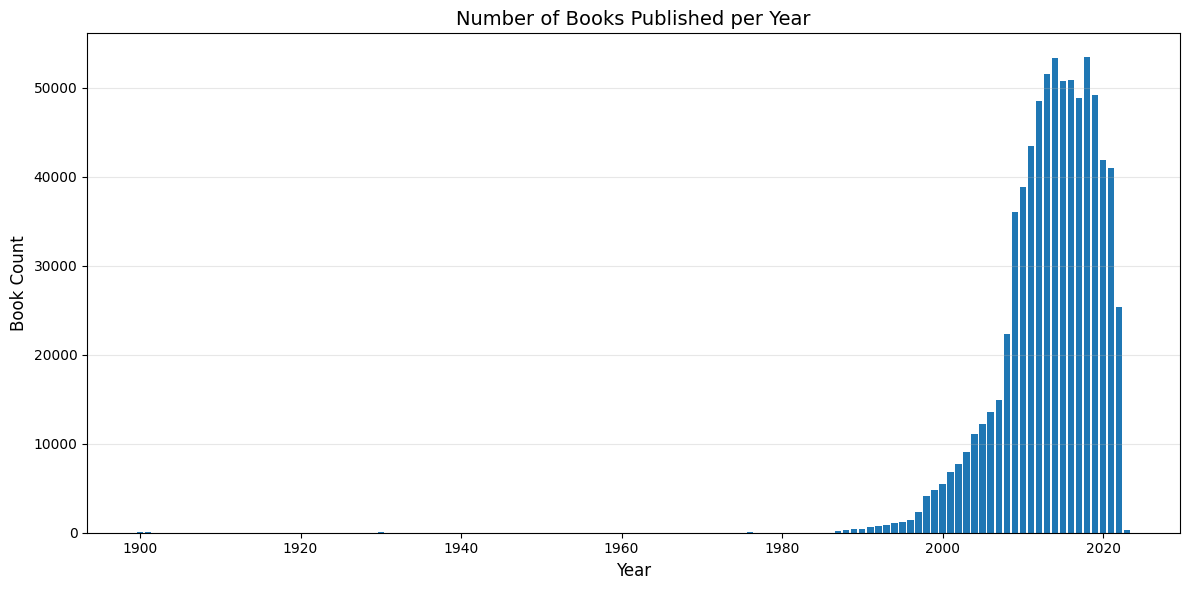

In [25]:
# Basic publication information by year
query = """
SELECT 
    CASE 
        WHEN TRY_CAST(SUBSTRING(metadata_record_titulos_fecha_aparicion, 1, 4) AS INTEGER) BETWEEN 1900 AND 2023 
        THEN CAST(SUBSTRING(metadata_record_titulos_fecha_aparicion, 1, 4) AS INTEGER)
        ELSE NULL 
    END AS publication_year,
    COUNT(*) AS book_count
FROM read_parquet('/data/aacF/aac_cerlalc_records*.parquet')
WHERE metadata_record_titulos_fecha_aparicion IS NOT NULL
GROUP BY publication_year
HAVING publication_year IS NOT NULL
ORDER BY publication_year
"""

result = con.execute(query).fetchdf()
print(f"Analysis of book publications by year ({len(result)} years):")
result.head(10)

# Visualization: Book count by year (only one visualization)
plt.figure(figsize=(12, 6))
plt.bar(result['publication_year'], result['book_count'])
plt.title('Number of Books Published per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Book Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Top subject and publisher combinations (100 total):


/tmp/ipykernel_2755/4212466018.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='viridis')


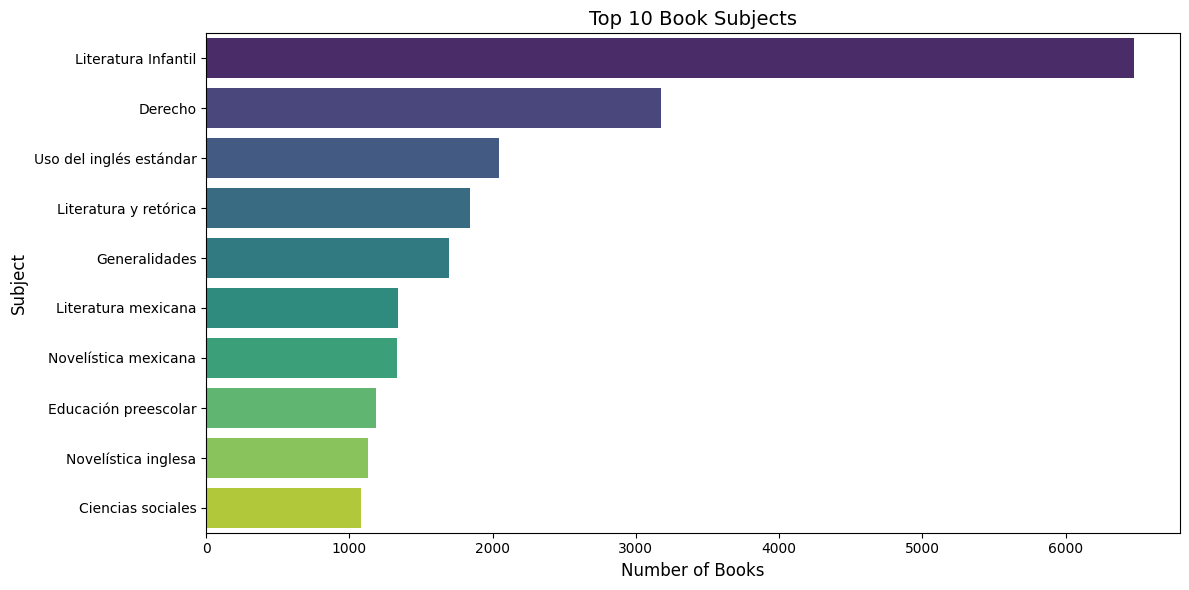

In [27]:
# Top subjects and publishers
query = """
SELECT 
    metadata_record_materias_rows_0__nombre AS subject,
    metadata_record_editores_rows_0__nombre AS publisher, 
    COUNT(*) AS book_count
FROM read_parquet('/data/aacF/aac_cerlalc_records*.parquet')
WHERE 
    metadata_record_materias_rows_0__nombre IS NOT NULL AND
    metadata_record_editores_rows_0__nombre IS NOT NULL
GROUP BY subject, publisher
ORDER BY book_count DESC
LIMIT 100
"""

result = con.execute(query).fetchdf()
print(f"Top subject and publisher combinations ({len(result)} total):")
result.head(10)

# Visualization: Top 10 subjects
top_subjects = result.groupby('subject')['book_count'].sum().sort_values(ascending=False).head(10)

# Single visualization: Top 10 Book Subjects
plt.figure(figsize=(12, 6))
sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='viridis')
plt.title('Top 10 Book Subjects', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Subject', fontsize=12)
plt.tight_layout()
plt.show()

# Chinese Architecture Analysis

Analysis of 46 publisher-year combinations:


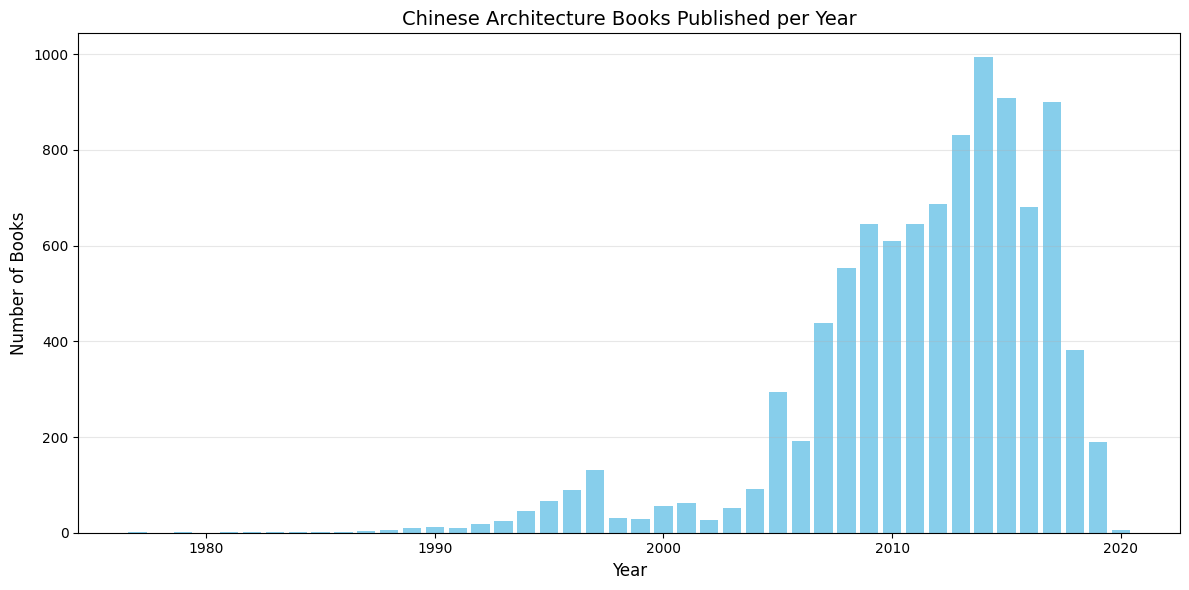

In [30]:
# Publication Analysis by Year and Publisher
query = """
SELECT 
    CASE 
        WHEN REGEXP_MATCHES("metadata_Publication date", '\\d{4}') 
        THEN CAST(REGEXP_EXTRACT("metadata_Publication date", '\\d{4}') AS INTEGER)
        ELSE NULL 
    END AS publication_year,
    "metadata_Publisher" AS publisher,
    COUNT(*) AS book_count
FROM read_parquet('/data/aacF/aac_chinese_architecture_records*.parquet')
WHERE "metadata_Publication date" IS NOT NULL
GROUP BY publication_year, publisher
HAVING publication_year IS NOT NULL
ORDER BY publication_year, book_count DESC
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} publisher-year combinations:")
result.head(10)

# Visualization: Publication trends over time
yearly_counts = result.groupby('publication_year')['book_count'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(yearly_counts['publication_year'], yearly_counts['book_count'], color='skyblue')
plt.title('Chinese Architecture Books Published per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Analysis of 51 category combinations:


/tmp/ipykernel_2755/3681298693.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_categories['book_count'].head(10),


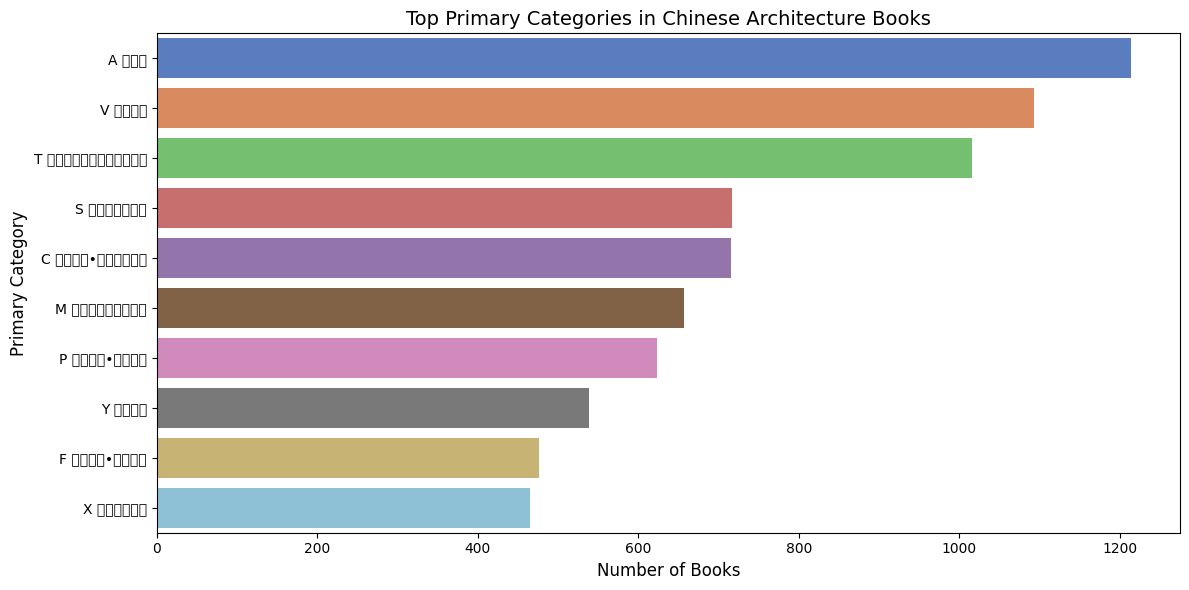

In [40]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

warnings.filterwarnings('ignore', category=UserWarning)

def set_chinese_font():
    # Try to find a font that supports Chinese characters
    available_fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    for font in available_fonts:
        if 'Noto' in font or 'SimHei' in font or 'AR PL UMing' in font:
            plt.rcParams['font.sans-serif'] = [font.split('/')[-1][:-4]]  # Extract font name
            plt.rcParams['axes.unicode_minus'] = False  # To ensure minus signs are rendered correctly
            return
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  
    plt.rcParams['axes.unicode_minus'] = False  # Ensure minus signs are rendered correctly

set_chinese_font()

query = """
SELECT 
    "metadata_﻿一级分类" AS primary_category,  -- Use the correct column name with invisible characters
    "metadata_二级分类" AS secondary_category,
    COUNT(*) AS book_count,
    COUNT(DISTINCT metadata_Author) AS author_count
FROM read_parquet('/data/aacF/aac_chinese_architecture_records*.parquet')
GROUP BY primary_category, secondary_category
ORDER BY book_count DESC
"""

# Execute the query and fetch the data
result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} category combinations:")
result.head(10)

# Visualization: Top primary categories (using the first 10)
primary_categories = result.groupby('primary_category').agg({
    'book_count': 'sum',
    'author_count': 'sum'
}).sort_values('book_count', ascending=False)

# Bar plot for top primary categories
plt.figure(figsize=(12, 6))
sns.barplot(x=primary_categories['book_count'].head(10), 
           y=primary_categories.head(10).index, palette='muted')
plt.title('Top Primary Categories in Chinese Architecture Books', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Primary Category', fontsize=12)
plt.tight_layout()
plt.show()


# Czech Records Analysis

Analysis of 1045 issues:


/tmp/ipykernel_2755/3289412026.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result['issue'].head(15), y=result['article_count'].head(15), palette='viridis')


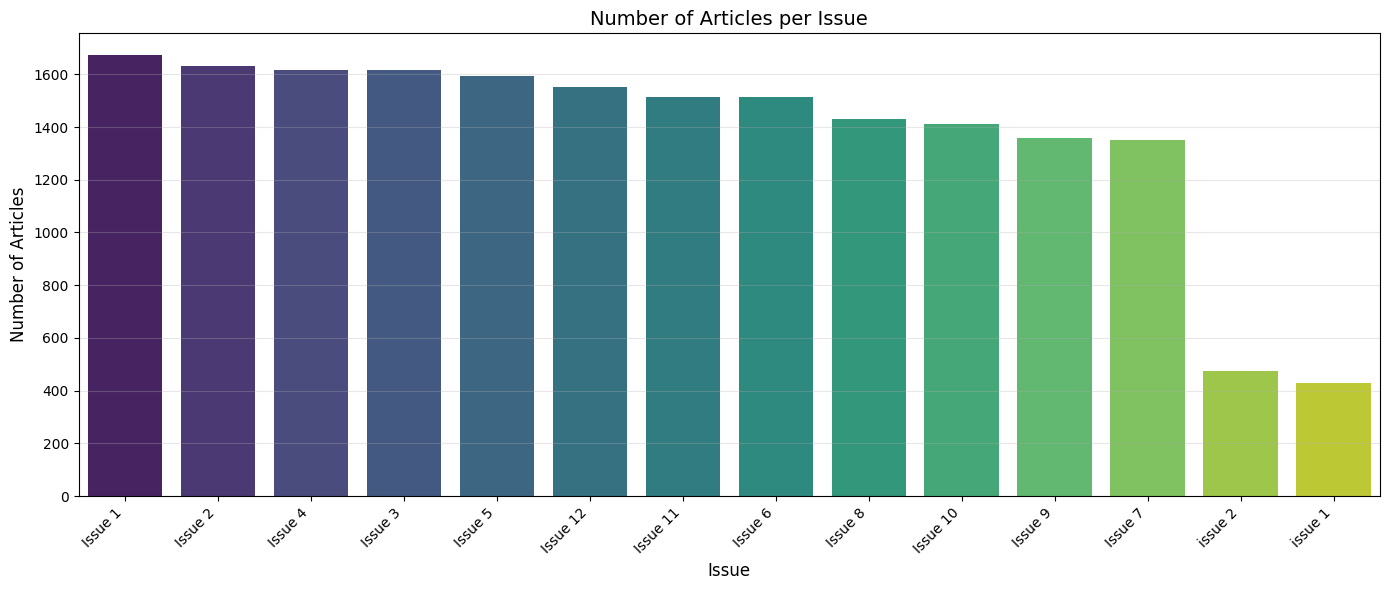

In [41]:
# Article Analysis by Source and Issue
query = """
SELECT 
    metadata_record_Issue AS issue,
    COUNT(*) AS article_count,
    COUNT(DISTINCT metadata_record_Authors) AS unique_authors,
    AVG(LENGTH(metadata_record_Abstract)) AS avg_abstract_length
FROM read_parquet('/data/aacF/aac_czech_oo42hcks_records*.parquet')
GROUP BY issue
ORDER BY article_count DESC
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} issues:")
result.head(10)

plt.figure(figsize=(14, 6))
sns.barplot(x=result['issue'].head(15), y=result['article_count'].head(15), palette='viridis')
plt.title('Number of Articles per Issue', fontsize=14)
plt.xlabel('Issue', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Retrieved 70249 articles with keyword information:


/tmp/ipykernel_2755/616283557.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


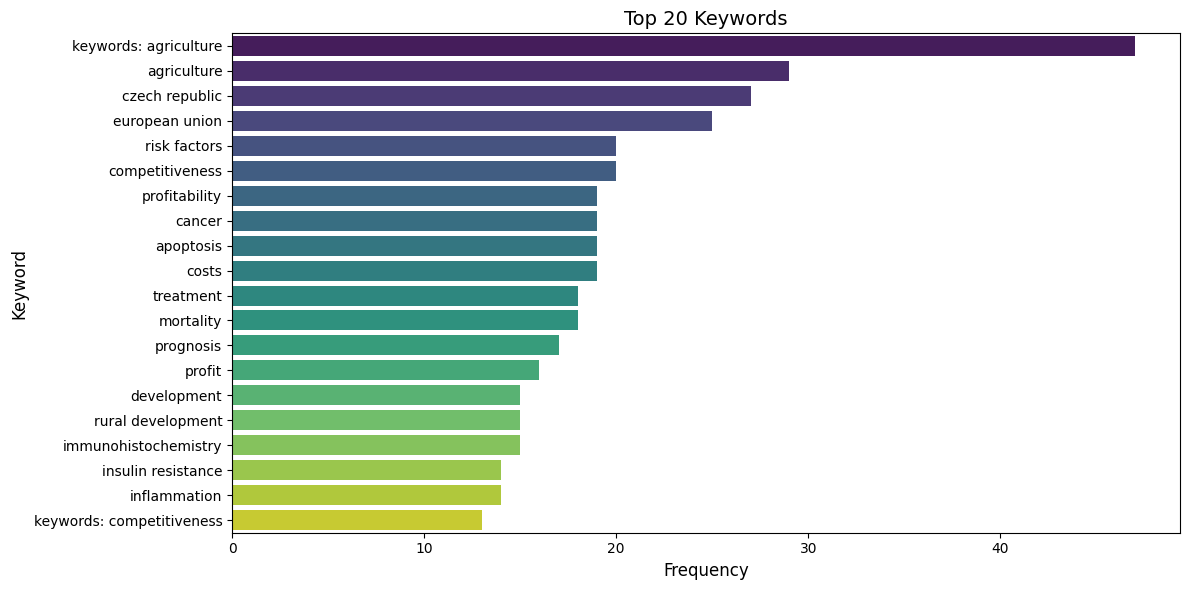

In [45]:
# Keyword Analysis
query = """
SELECT 
    metadata_record_Keywords AS keywords
FROM read_parquet('/data/aacF/aac_czech_oo42hcks_records*.parquet')
"""

result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} articles with keyword information:")
result.head(5)

# Processing for keyword analysis
all_keywords = []
for keywords in result['keywords'].dropna():
    keyword_list = keywords.split(',')
    all_keywords.extend([k.strip().lower() for k in keyword_list if k.strip()])

# Count keyword occurrences
keyword_counts = pd.Series(all_keywords).value_counts()
top_keywords = keyword_counts.head(20)

# Visualization: Top 20 Keywords
plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('Top 20 Keywords', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.tight_layout()
plt.show()


# DuXiu Files Analysis

Analysis of file sizes (3815329 distinct file sizes):
   metadata_filesize  file_count  min_size  max_size    avg_size  \
0            7356764           5   7356764   7356764   7356764.0   
1            5927809           5   5927809   5927809   5927809.0   
2           12687180           4  12687180  12687180  12687180.0   
3           13947463           4  13947463  13947463  13947463.0   
4            6633812           4   6633812   6633812   6633812.0   
5           11846729           4  11846729  11846729  11846729.0   
6           11553820           4  11553820  11553820  11553820.0   
7            5737098           4   5737098   5737098   5737098.0   
8            3076511           4   3076511   3076511   3076511.0   
9            6581905           4   6581905   6581905   6581905.0   

   file_size_kb  file_size_mb  file_size_gb  
0   7184.339844      7.015957      0.006852  
1   5788.875977      5.653199      0.005521  
2  12389.824219     12.099438      0.011816  
3  13620.5693

/tmp/ipykernel_4651/1463403665.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result['metadata_filesize'].head(15), y=result['file_count'].head(15), palette='viridis')


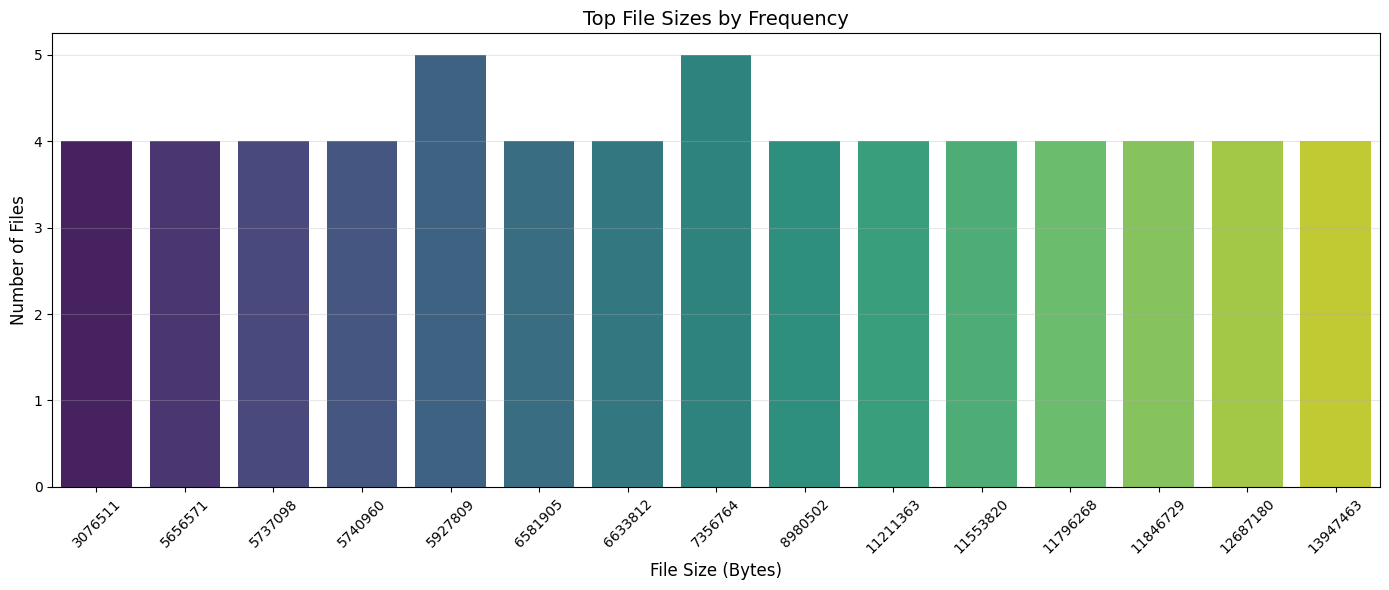

In [4]:
# File Size Distribution and Statistics
query = """
SELECT 
    metadata_filesize,
    COUNT(*) AS file_count,
    MIN(CAST(metadata_filesize AS BIGINT)) AS min_size,
    MAX(CAST(metadata_filesize AS BIGINT)) AS max_size,
    AVG(CAST(metadata_filesize AS BIGINT)) AS avg_size
FROM read_parquet('/data/aacF/aac_duxiu_files*.parquet')
GROUP BY metadata_filesize
ORDER BY file_count DESC
"""

result = con.execute(query).fetchdf()

# Ensure metadata_filesize is treated as numeric
result['metadata_filesize'] = pd.to_numeric(result['metadata_filesize'], errors='coerce')

# Add more readable size formats
result['file_size_kb'] = result['metadata_filesize'] / 1024
result['file_size_mb'] = result['metadata_filesize'] / (1024**2)
result['file_size_gb'] = result['metadata_filesize'] / (1024**3)

# Print file size analysis
print(f"Analysis of file sizes ({len(result)} distinct file sizes):")
print(result.head(10))

# Visualization: Distribution of File Sizes
plt.figure(figsize=(14, 6))
sns.barplot(x=result['metadata_filesize'].head(15), y=result['file_count'].head(15), palette='viridis')
plt.title('Top File Sizes by Frequency', fontsize=14)
plt.xlabel('File Size (Bytes)', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Analysis of 256 MD5 hash prefixes:
  md5_prefix  hash_count  unique_hashes      avg_size  avg_size_mb
0         a4       15617          15617  5.209383e+07    49.680547
1         af       15588          15588  5.348721e+07    51.009377
2         87       15555          15555  5.189484e+07    49.490781
3         00       15545          15545  5.214498e+07    49.729329
4         7c       15525          15525  5.160571e+07    49.215037
5         19       15512          15512  5.359722e+07    51.114291
6         4f       15503          15503  5.374680e+07    51.256943
7         1f       15500          15500  5.264843e+07    50.209454
8         04       15495          15495  5.317650e+07    50.713064
9         9d       15492          15492  5.289417e+07    50.443816


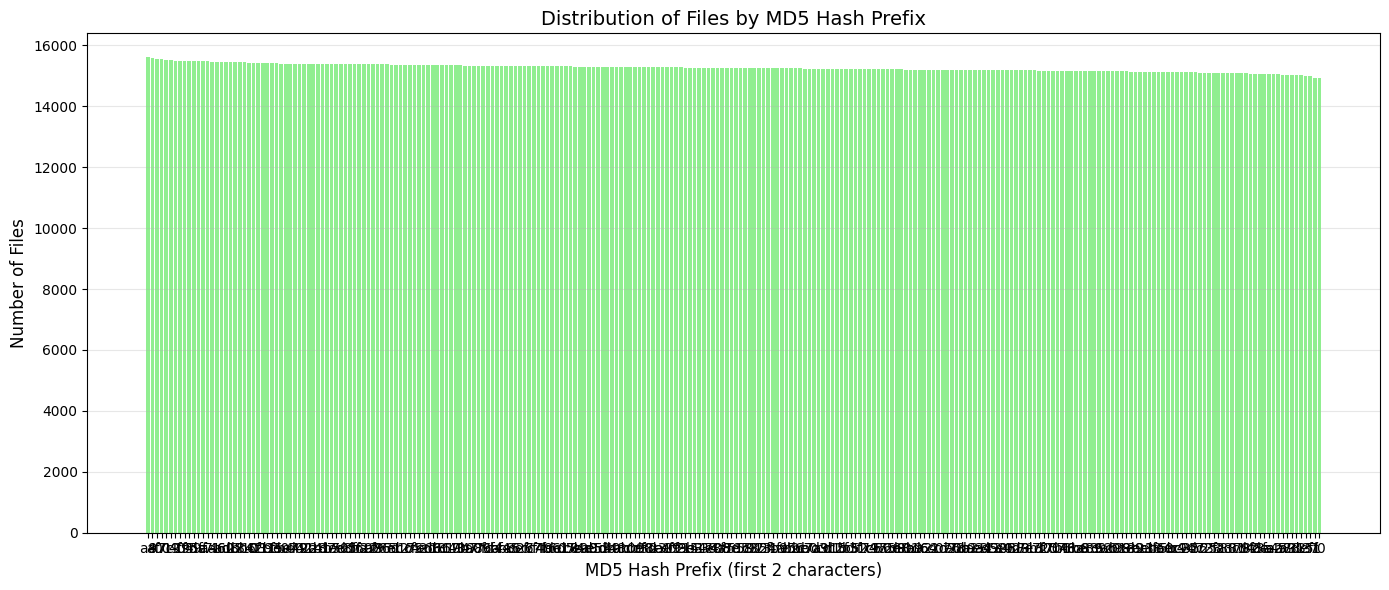

Percentage of unique MD5 hashes: 100.00%
Total files analyzed: 3,907,821
Unique MD5 hashes: 3,907,821


In [5]:
# MD5 Hash Pattern Analysis
query = """
SELECT 
    LEFT(metadata_md5, 2) AS md5_prefix,
    COUNT(*) AS hash_count,
    COUNT(DISTINCT metadata_md5) AS unique_hashes,
    AVG(CAST(metadata_filesize AS BIGINT)) AS avg_size
FROM read_parquet('/data/aacF/aac_duxiu_files*.parquet')
GROUP BY md5_prefix
ORDER BY hash_count DESC
"""

result = con.execute(query).fetchdf()

# Add column with more readable size format
result['avg_size_mb'] = result['avg_size'] / (1024**2)

print(f"Analysis of {len(result)} MD5 hash prefixes:")
print(result.head(10))

# Visualization 1: Hash count distribution
plt.figure(figsize=(14, 6))
plt.bar(result['md5_prefix'], result['hash_count'], color='lightgreen')
plt.title('Distribution of Files by MD5 Hash Prefix', fontsize=14)
plt.xlabel('MD5 Hash Prefix (first 2 characters)', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate statistics about hash uniqueness
hash_uniqueness = result['unique_hashes'].sum() / result['hash_count'].sum() * 100

print(f"Percentage of unique MD5 hashes: {hash_uniqueness:.2f}%")
print(f"Total files analyzed: {result['hash_count'].sum():,}")
print(f"Unique MD5 hashes: {result['unique_hashes'].sum():,}")


# DuXiu Records Analysis

Analysis of 7551 sources:


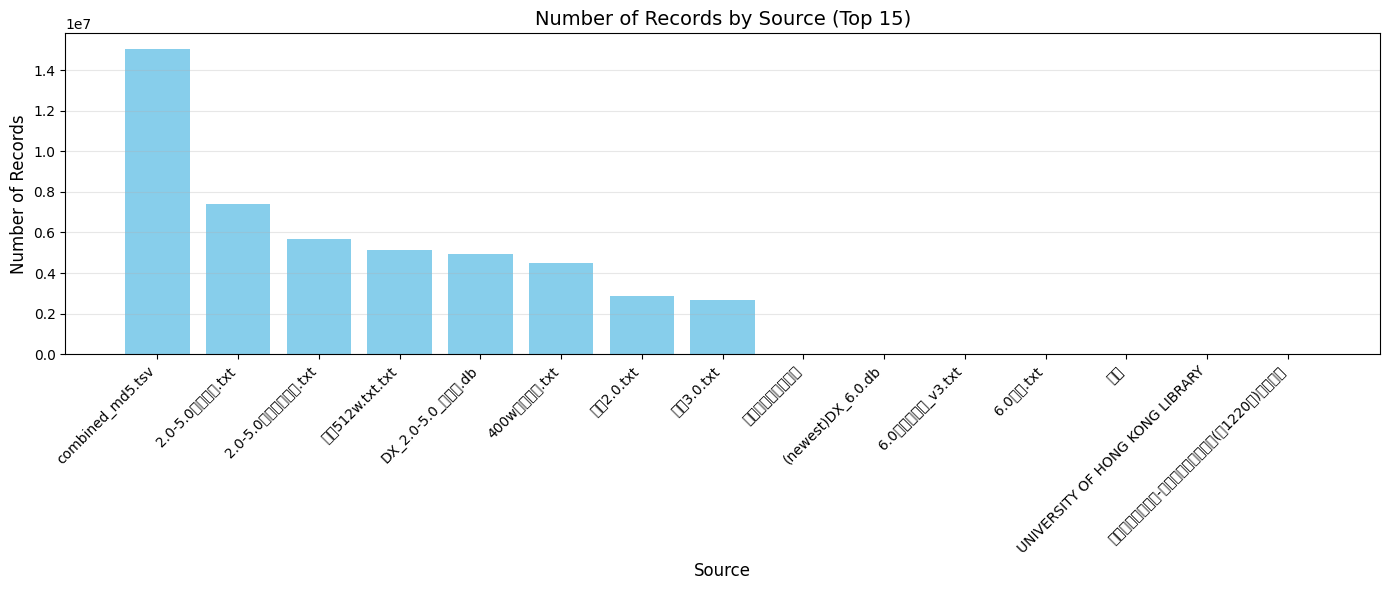

In [3]:
import warnings
import matplotlib.pyplot as plt

# Suppress warnings (ensure warnings module is imported)
warnings.filterwarnings('ignore', category=UserWarning)

# Basic ISBN and Source Analysis
query = """
SELECT 
    metadata_record_source AS source,
    COUNT(*) AS record_count,
    COUNT(metadata_record_isbn) AS isbn_count,
    COUNT(metadata_record_isbn_10) AS isbn10_count,
    COUNT(metadata_record_isbn_13) AS isbn13_count,
    COUNT(DISTINCT metadata_record_isbn) AS unique_isbns
FROM read_parquet('/data/aacF/aac_duxiu_records*.parquet')
WHERE metadata_record_source IS NOT NULL
GROUP BY source
ORDER BY record_count DESC
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} sources:")
result.head(10)

# Visualization: Record counts by source (only one visualization)
plt.figure(figsize=(14, 6))
source_counts = result.head(15)  # Top 15 sources
plt.bar(source_counts['source'], source_counts['record_count'], color='skyblue')
plt.title('Number of Records by Source (Top 15)', fontsize=14)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

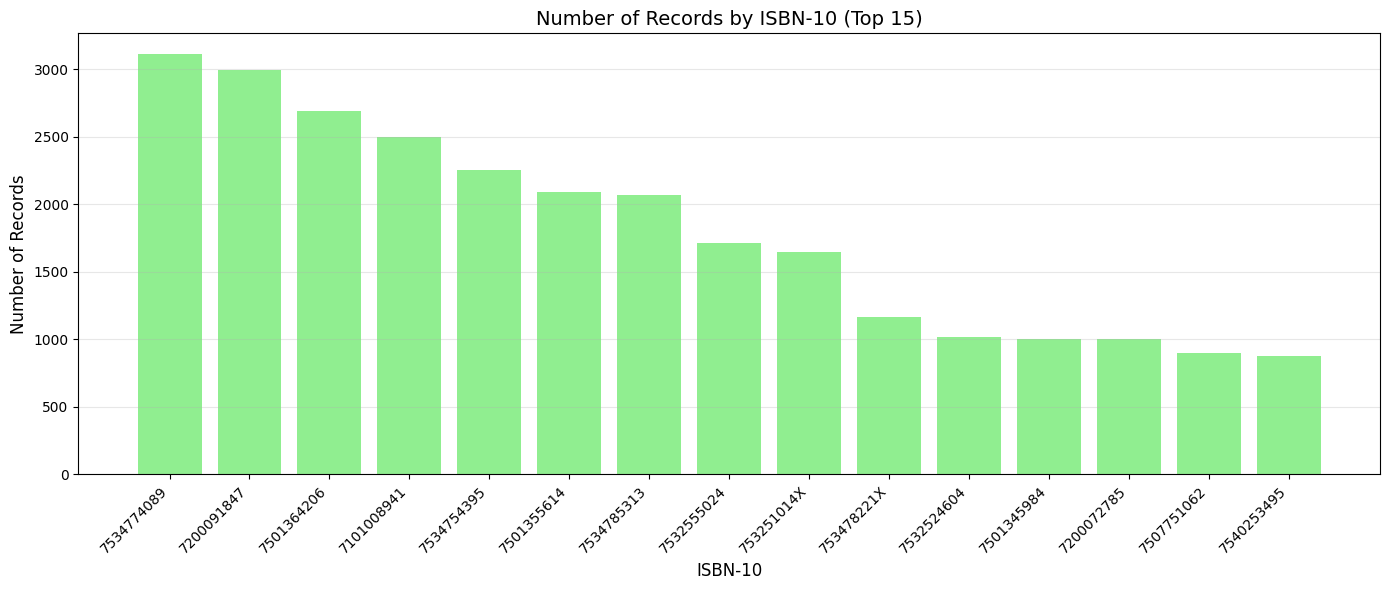

In [4]:
import matplotlib.pyplot as plt

# SQL query to get the number of records by ISBN-10
query = """
SELECT 
    metadata_record_isbn_10 AS isbn_10, 
    COUNT(*) AS record_count
FROM read_parquet('/data/aacF/aac_duxiu_records*.parquet')
WHERE metadata_record_isbn_10 IS NOT NULL
GROUP BY isbn_10
ORDER BY record_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchall()

# Separate the results into two lists for plotting
isbn_10s = [row[0] if row[0] is not None else 'Unknown' for row in result]  # Replace None with 'Unknown'
record_counts = [row[1] for row in result]  # Second element is 'record_count'

# Ensure that if ISBN-10s are too long to fit on the x-axis, we display only the top 15
top_isbn_10s = isbn_10s[:15]
top_record_counts = record_counts[:15]

# Visualization: Number of records by ISBN-10 (only one visualization)
plt.figure(figsize=(14, 6))
plt.bar(top_isbn_10s, top_record_counts, color='lightgreen')
plt.title('Number of Records by ISBN-10 (Top 15)', fontsize=14)
plt.xlabel('ISBN-10', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# EBSCO Records Analysis

Analysis of 1683 year-document type-language combinations:


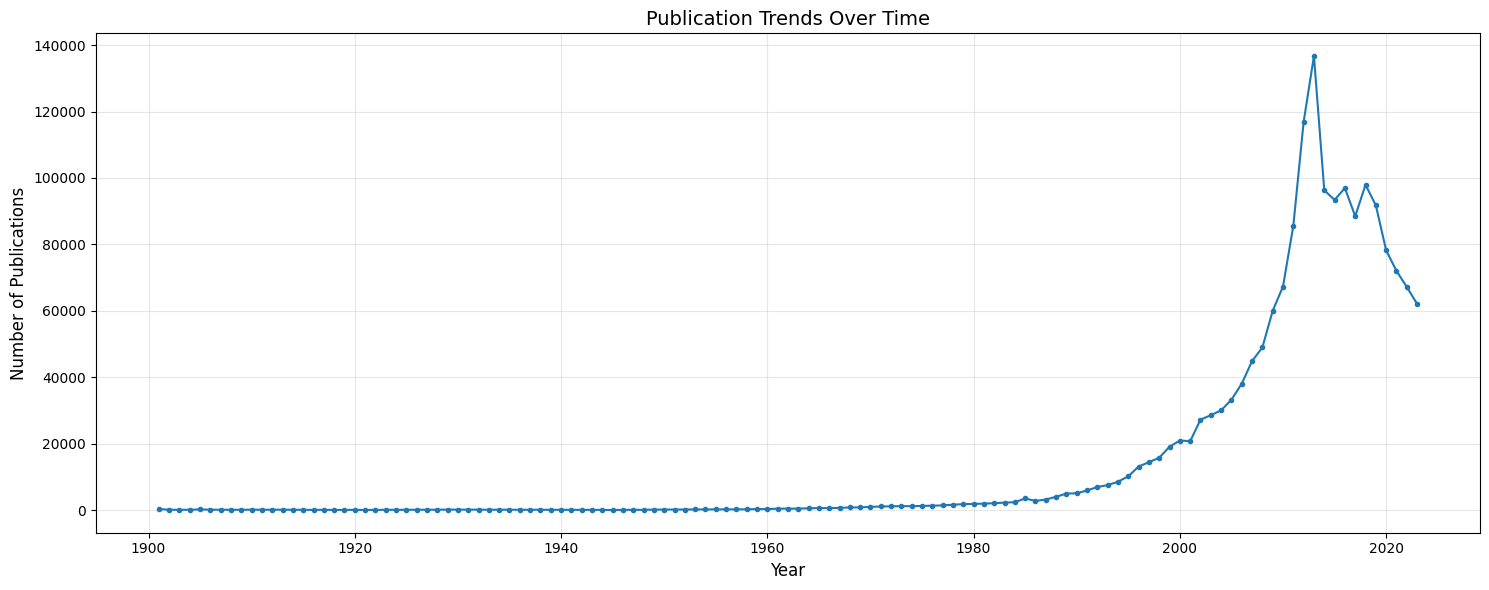

In [6]:
import matplotlib.pyplot as plt

# SQL query to get the number of records by publication year, document type, and language
query = """
SELECT 
    metadata_header_pubinfo_date_year AS publication_year,
    metadata_header_artinfo_doc_type AS document_type,
    metadata_header_language_name AS language,
    COUNT(*) AS record_count
FROM read_parquet('/data/aacF/aac_ebscohost_records*.parquet')
WHERE 
    metadata_header_pubinfo_date_year IS NOT NULL 
    AND metadata_header_pubinfo_date_year != ''  -- Exclude empty strings
    AND CAST(metadata_header_pubinfo_date_year AS INTEGER) > 1900 
    AND CAST(metadata_header_pubinfo_date_year AS INTEGER) <= 2023
GROUP BY publication_year, document_type, language
ORDER BY publication_year DESC, record_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Convert the 'publication_year' column to numeric
result['publication_year'] = pd.to_numeric(result['publication_year'])

# Display the first few rows of the result
print(f"Analysis of {len(result)} year-document type-language combinations:")
result.head(10)

# Visualization 1: Publication trends over time
plt.figure(figsize=(15, 6))
year_counts = result.groupby('publication_year')['record_count'].sum()  # Summing record counts by year
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', markersize=3)
plt.title('Publication Trends Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Analysis of 4980 subjects:


/tmp/ipykernel_5696/3224603463.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects['record_count'], y=top_subjects['subject'], palette='muted')


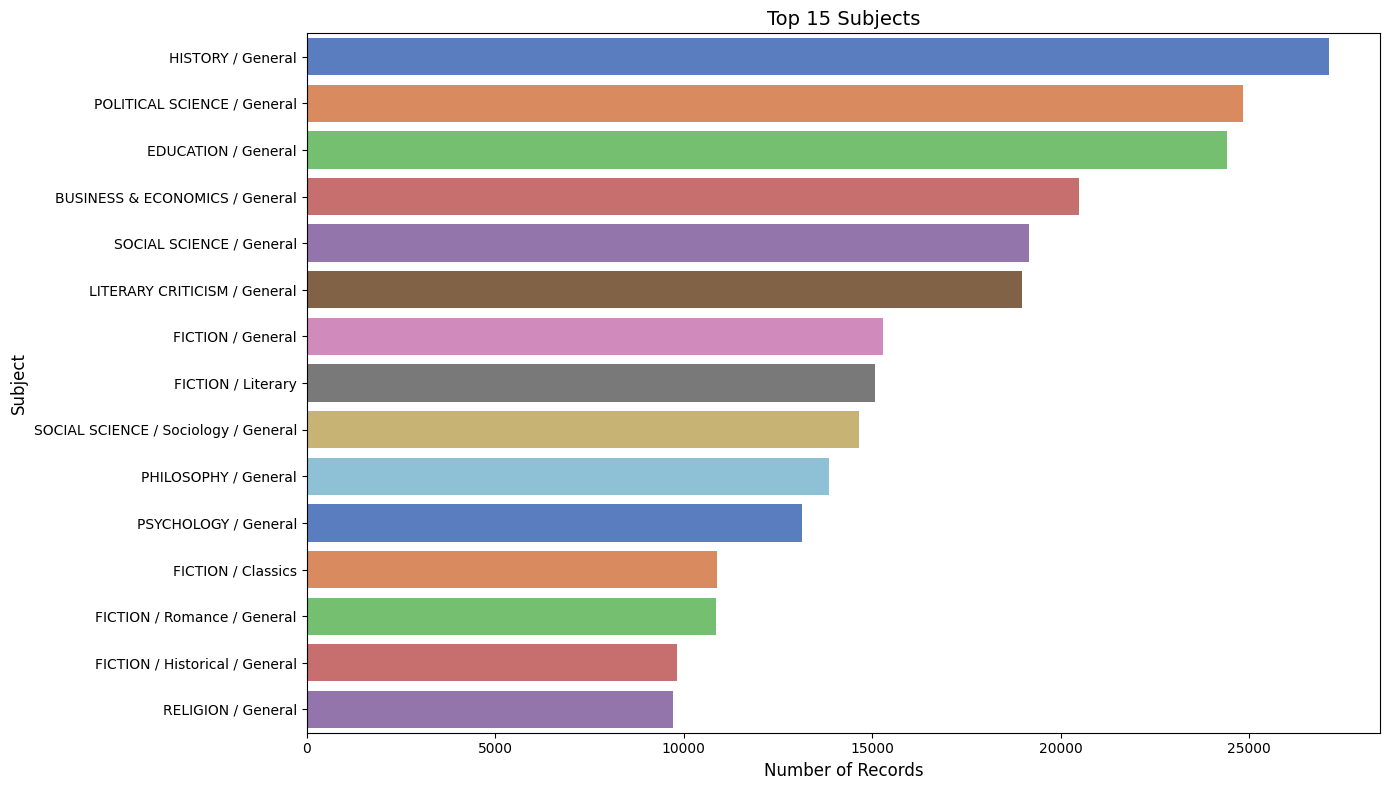

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# SQL query to analyze the subjects and subject types
query = """
SELECT 
    metadata_header_artinfo_subject_groups_0__Subject AS subject,
    metadata_header_artinfo_subject_groups_0__Type AS subject_type,
    COUNT(*) AS record_count
FROM read_parquet('/data/aacF/aac_ebscohost_records*.parquet')
WHERE 
    metadata_header_artinfo_subject_groups_0__Subject IS NOT NULL AND
    metadata_header_artinfo_subject_groups_0__Subject != ''
GROUP BY subject, subject_type
ORDER BY record_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} subjects:")
result.head(10)

# Visualization 1: Top subjects
top_subjects = result.head(15)  # Top 15 subjects
plt.figure(figsize=(14, 8))
sns.barplot(x=top_subjects['record_count'], y=top_subjects['subject'], palette='muted')
plt.title('Top 15 Subjects', fontsize=14)
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Subject', fontsize=12)
plt.tight_layout()
plt.show()


# Google Books Analysis

Analysis of 11 language combinations:
  language  book_count
0       en    54733449
1       de    10758141
2       fr     8175845
3       es     5484395
4    zh-CN     4405922


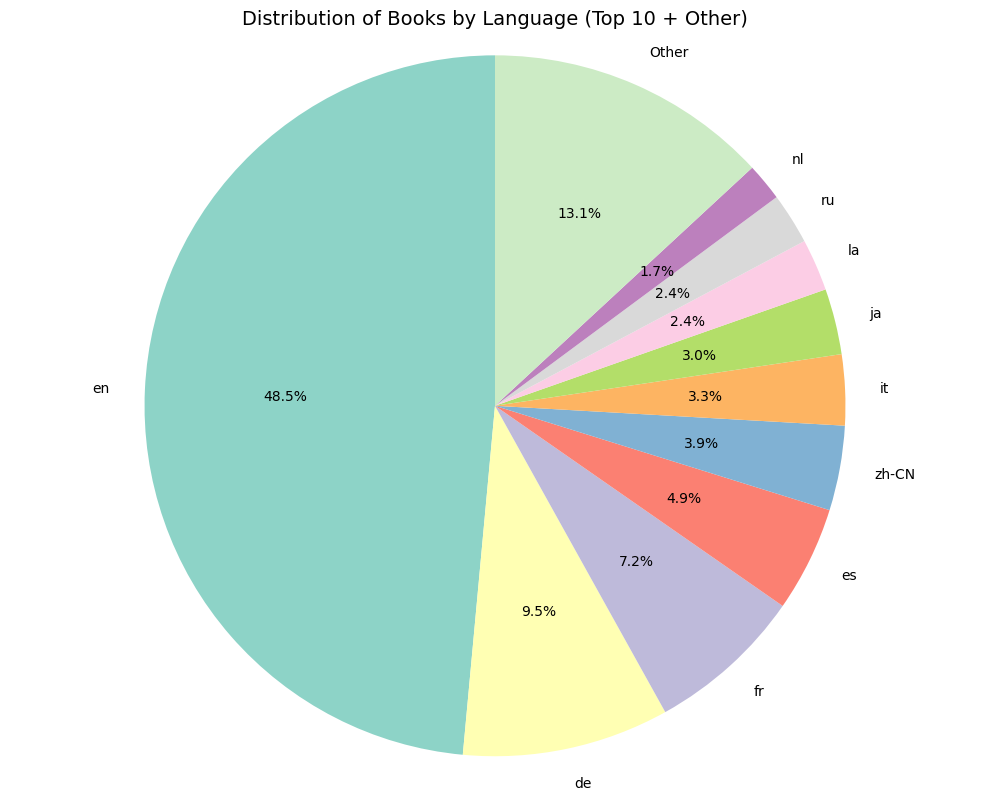

In [25]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# SQL query to analyze books by language, keeping top 10 languages and grouping others as "Other"
query = """
WITH top_languages AS (
    SELECT 
        metadata_language AS language,
        COUNT(*) AS book_count
    FROM read_parquet('/data/aacF/aac_gbooks_records*.parquet')
    WHERE metadata_language IS NOT NULL
    GROUP BY language
    ORDER BY book_count DESC
    LIMIT 10
)
SELECT 
    language,
    book_count
FROM top_languages
UNION ALL
SELECT 
    'Other' AS language,
    COUNT(*) AS book_count
FROM read_parquet('/data/aacF/aac_gbooks_records*.parquet')
WHERE metadata_language IS NOT NULL
    AND metadata_language NOT IN (SELECT language FROM top_languages)
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Display the first few rows of the result
print(f"Analysis of {len(result)} language combinations:")
print(result.head())

# Visualization: Pie chart for top 10 languages and 'Other'
plt.figure(figsize=(10, 8))
plt.pie(result['book_count'], labels=result['language'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3', len(result)))
plt.title('Distribution of Books by Language (Top 10 + Other)', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()
plt.show()


Analysis of 705 identifier type-language combinations:
  identifier_type language  book_count   avg_pages  min_pages  max_pages  \
0           OTHER       en    20957814  217.325405          1     336404   
1         ISBN_10       en    15743762  216.213638          1     188871   
2           OTHER       de     5848224  241.156554          1     182221   
3           OTHER       fr     4475285  283.644207          1     412030   
4         ISBN_13       en     4209504  219.076148          1      99998   

   median_pages  
0           125  
1           146  
2           144  
3           206  
4           169  


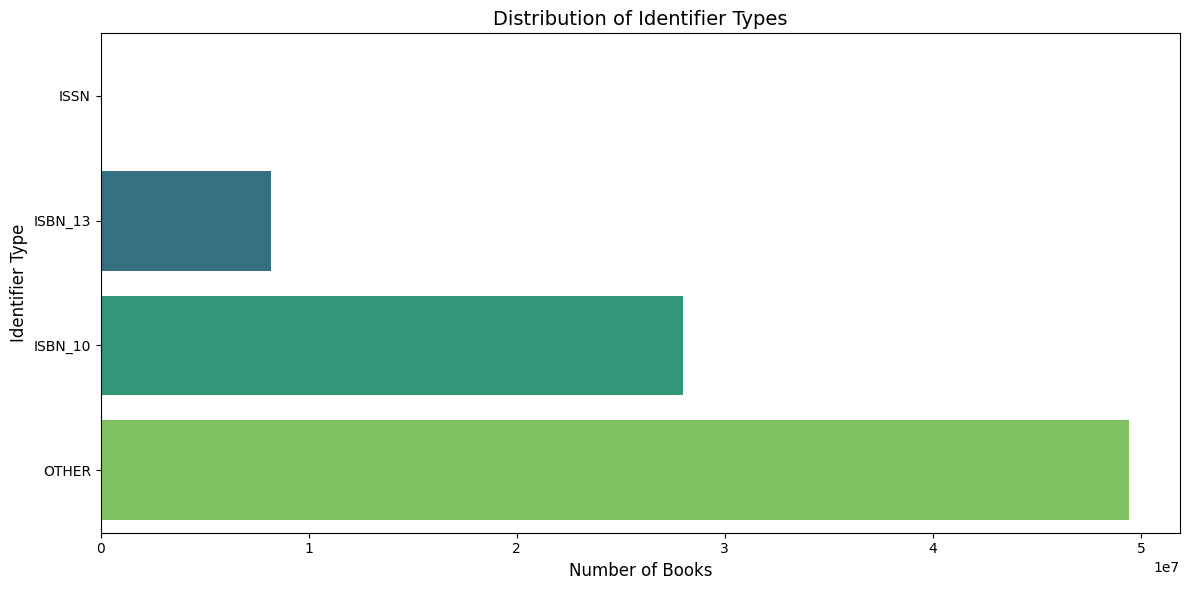


Summary Statistics:
       book_count  avg_pages  median_pages
sum   86476117.00        NaN           NaN
mean    122661.16     185.75        137.88
min           NaN       8.00           NaN
max           NaN     927.20           NaN


In [26]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# Page count and ISBN analysis
query = """
WITH isbn_data AS (
    SELECT 
        CAST(metadata_pageCount AS INTEGER) AS page_count,
        metadata_industryIdentifiers_0__type AS identifier_type,
        metadata_industryIdentifiers_0__identifier AS identifier,
        metadata_language AS language
    FROM read_parquet('/data/aacF/aac_gbooks_records*.parquet')
    WHERE CAST(metadata_pageCount AS INTEGER) > 0  -- Explicitly cast to INTEGER for comparison
)
SELECT 
    identifier_type,
    language,
    COUNT(*) AS book_count,
    AVG(page_count) AS avg_pages,
    MIN(page_count) AS min_pages,
    MAX(page_count) AS max_pages,
    APPROX_QUANTILE(page_count, 0.5) AS median_pages
FROM isbn_data
GROUP BY identifier_type, language
ORDER BY book_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Print the result to check
print(f"Analysis of {len(result)} identifier type-language combinations:")
print(result.head())

# Visualization: Identifier types and their counts (only one visualization)
plt.figure(figsize=(12, 6))
identifier_counts = result.groupby('identifier_type')['book_count'].sum().sort_values(ascending=True)
sns.barplot(x=identifier_counts.values, y=identifier_counts.index, palette='viridis')
plt.title('Distribution of Identifier Types', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Identifier Type', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics table
summary_stats = result.agg({
    'book_count': ['sum', 'mean'],
    'avg_pages': ['mean', 'min', 'max'],
    'median_pages': 'mean'
}).round(2)

print("\nSummary Statistics:")
print(summary_stats)


# Goodreads Analysis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Analyzed 11122860 books:
  publication_year language_code          format  avg_rating  page_count  \
0             2003           eng       Hardcover        0.00         350   
1             2010           zho       Paperback        3.33         528   
2             2018           eng       Paperback        3.67         172   
3             2023           eng  Kindle Edition        4.70         340   
4             2021           eng       Paperback        4.00        <NA>   

   ratings_count  
0              0  
1              3  
2              3  
3             54  
4              3  


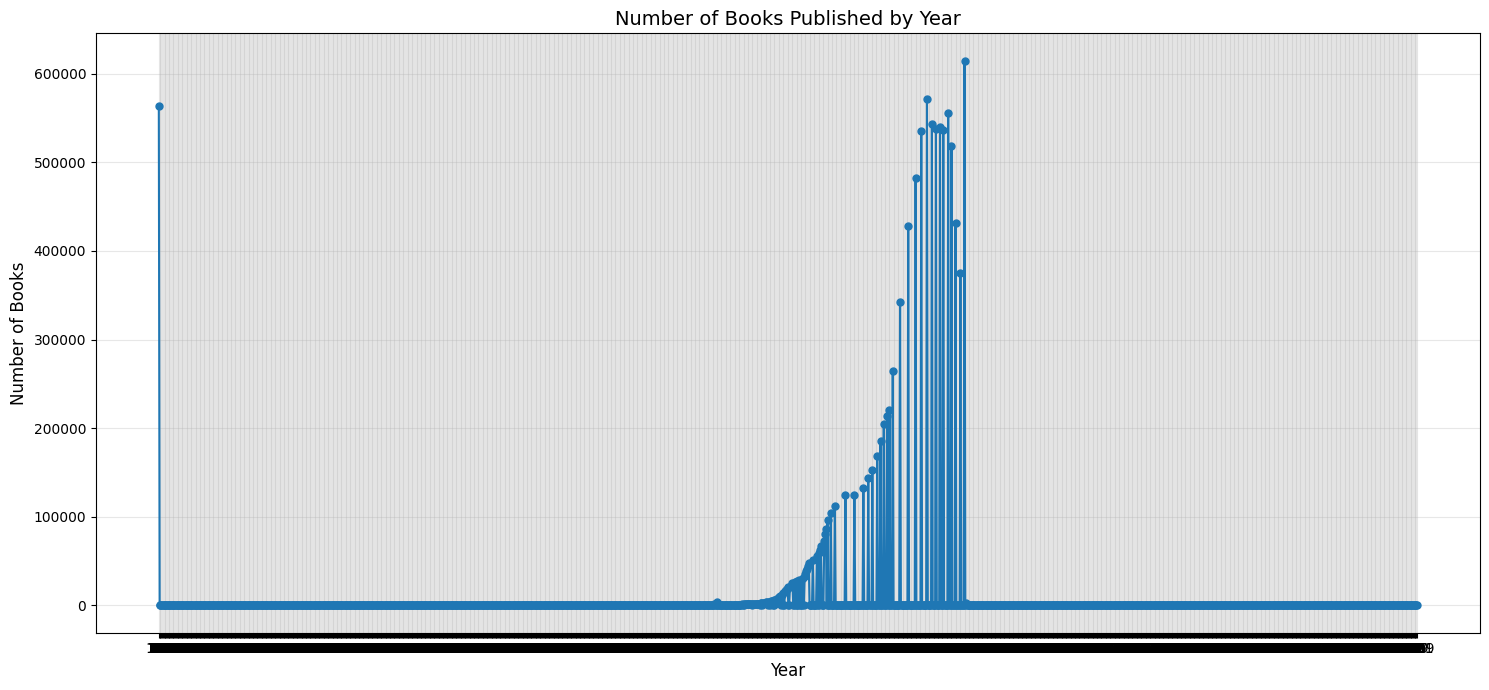

In [29]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# SQL query to analyze book statistics with handling of empty values
query = """
SELECT 
    REGEXP_EXTRACT(metadata_record, '<publication_year>(\\d+)</publication_year>', 1) AS publication_year,
    REGEXP_EXTRACT(metadata_record, '<language_code>([^<]+)</language_code>', 1) AS language_code,
    REGEXP_EXTRACT(metadata_record, '<format>([^<]+)</format>', 1) AS format,
    CASE 
        WHEN REGEXP_EXTRACT(metadata_record, '<average_rating>([^<]+)</average_rating>', 1) != '' 
        THEN CAST(REGEXP_EXTRACT(metadata_record, '<average_rating>([^<]+)</average_rating>', 1) AS FLOAT)
        ELSE NULL
    END AS avg_rating,
    CASE 
        WHEN REGEXP_EXTRACT(metadata_record, '<num_pages>(\\d+)</num_pages>', 1) != '' 
        THEN CAST(REGEXP_EXTRACT(metadata_record, '<num_pages>(\\d+)</num_pages>', 1) AS INTEGER)
        ELSE NULL
    END AS page_count,
    CASE 
        WHEN REGEXP_EXTRACT(metadata_record, '<ratings_count>(\\d+)</ratings_count>', 1) != '' 
        THEN CAST(REGEXP_EXTRACT(metadata_record, '<ratings_count>(\\d+)</ratings_count>', 1) AS INTEGER)
        ELSE NULL
    END AS ratings_count
FROM read_parquet('/data/aacF/aac_goodreads_records*.parquet')
WHERE metadata_record IS NOT NULL
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Display the first few rows of the result
print(f"Analyzed {len(result)} books:")
print(result.head())

# Visualization: Publications over time
plt.figure(figsize=(15, 7))
year_counts = result['publication_year'].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', markersize=5)
plt.title('Number of Books Published by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Retrieved 11122860 book-author records:
                                     publisher         author_name  \
0                              Ashgate Pub Ltd     Peter Bartelmus   
1                                         岳麓书社            （古希腊）柏拉图   
2  CreateSpace Independent Publishing Platform        Vance Morris   
3                                               Fierce Matchmaking   
4                                                     Andra Simons   

   review_count         isbn13      title  
0             0  9780754622321             
1             1  9787807613732        理想国  
2             2  9781721677177             
3             6                            
4             0  9781909570078  Turtlemen  


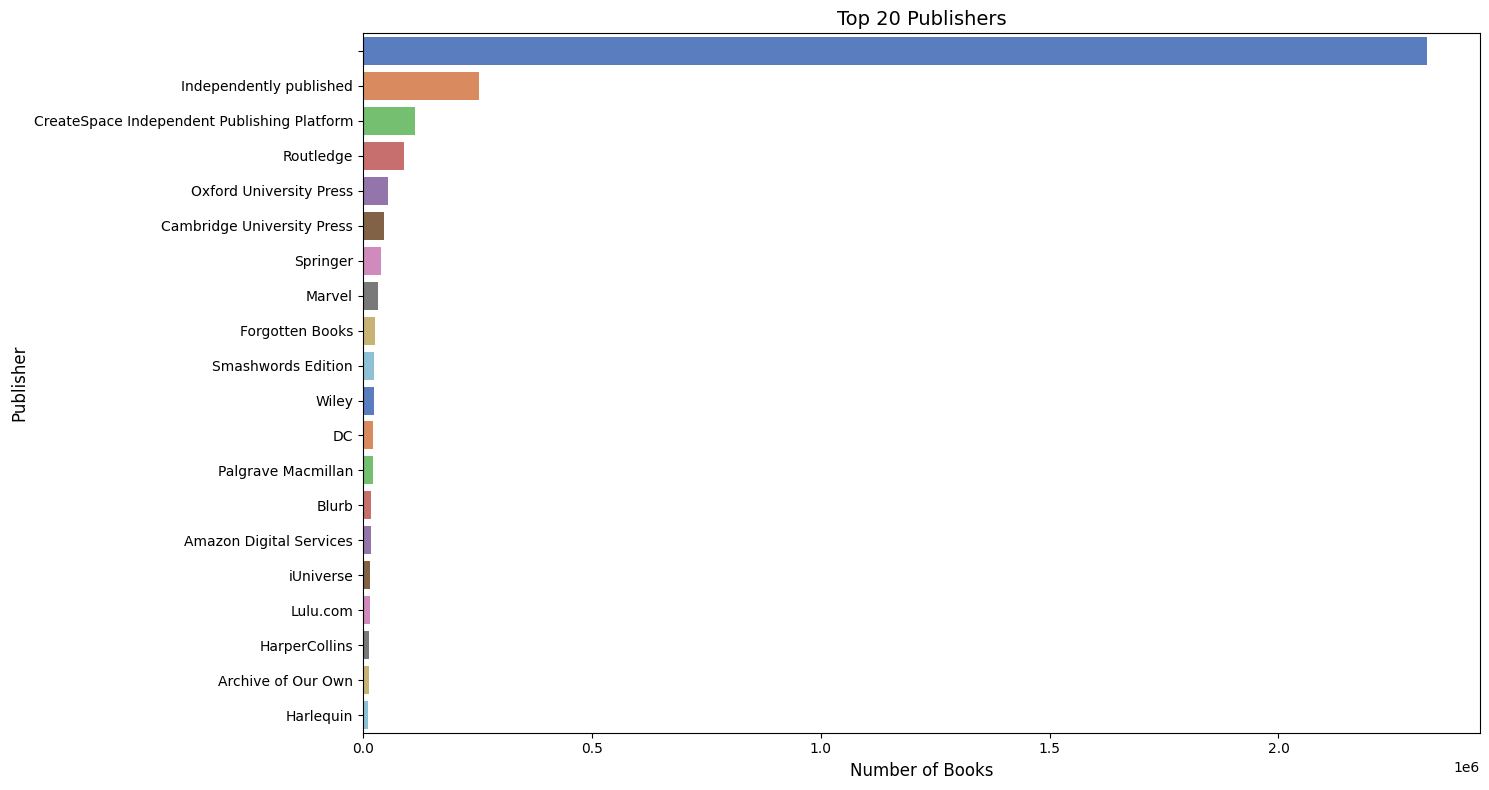


Summary Statistics:
Total Books: 11,122,860.00
Unique Publishers: 1,097,348.00
Unique Authors: 3,601,708.00
Books with ISBN-13: 11,122,860.00
Average Reviews per Book: 12.97


In [31]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# SQL query to analyze book statistics, focusing on publishers and authors with improved handling of empty strings
query = """
SELECT 
    REGEXP_EXTRACT(metadata_record, '<publisher>([^<]+)</publisher>', 1) AS publisher,
    REGEXP_EXTRACT(metadata_record, '<name>([^<]+)</name>', 1) AS author_name,
    CASE 
        WHEN REGEXP_EXTRACT(metadata_record, '<text_reviews_count>(\\d+)</text_reviews_count>', 1) != '' 
        THEN CAST(REGEXP_EXTRACT(metadata_record, '<text_reviews_count>(\\d+)</text_reviews_count>', 1) AS INTEGER)
        ELSE NULL
    END AS review_count,
    REGEXP_EXTRACT(metadata_record, '<isbn13>(\\d+)</isbn13>', 1) AS isbn13,
    REGEXP_EXTRACT(metadata_record, '<title>([^<]+)</title>', 1) AS title
FROM read_parquet('/data/aacF/aac_goodreads_records*.parquet')
WHERE metadata_record IS NOT NULL
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Display the first few rows of the result
print(f"Retrieved {len(result)} book-author records:")
print(result.head())

# Visualization: Top publishers
plt.figure(figsize=(15, 8))
top_publishers = result['publisher'].value_counts().head(20)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='muted')
plt.title('Top 20 Publishers', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
summary_stats = {
    'Total Books': len(result),
    'Unique Publishers': result['publisher'].nunique(),
    'Unique Authors': result['author_name'].nunique(),
    'Books with ISBN-13': result['isbn13'].notna().sum(),
    'Average Reviews per Book': result['review_count'].mean()
}

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:,.2f}")


# HathiTrust Analysis

In [35]:
# Adjusted SQL query using 'metadata_filepath' (or whatever column is appropriate)
query = """
SELECT 
    metadata_filepath AS file_path,  -- Adjust the column name here
    COUNT(*) AS file_count,
    SUM(CAST(metadata_filesize AS BIGINT)) AS total_size,
    AVG(CAST(metadata_filesize AS BIGINT)) AS avg_size,
    MIN(CAST(metadata_filesize AS BIGINT)) AS min_size,
    MAX(CAST(metadata_filesize AS BIGINT)) AS max_size
FROM read_parquet('/data/aacF/aac_hathitrust_files*.parquet')
GROUP BY file_path  -- Use the correct column for file path or folder
ORDER BY file_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Convert sizes to MB for better readability
result['total_size_mb'] = result['total_size'] / (1024 * 1024)
result['avg_size_mb'] = result['avg_size'] / (1024 * 1024)

# Show the results
print(f"Analysis of {len(result)} data folders:")
print(result.head())


Analysis of 7832067 data folders:
                                           file_path  file_count  total_size  \
0  mdp/pairtree_root/35/11/22/03/94/68/94/3511220...           1   1343592.0   
1  mdp/pairtree_root/39/01/50/01/21/82/32/3901500...           1    239113.0   
2  mdp/pairtree_root/35/11/22/03/95/82/38/3511220...           1    759823.0   
3  mdp/pairtree_root/35/11/21/05/00/86/37/3511210...           1   1096028.0   
4  mdp/pairtree_root/39/01/50/01/29/30/94/3901500...           1    697597.0   

    avg_size  min_size  max_size  total_size_mb  avg_size_mb  
0  1343592.0   1343592   1343592       1.281349     1.281349  
1   239113.0    239113    239113       0.228036     0.228036  
2   759823.0    759823    759823       0.724624     0.724624  
3  1096028.0   1096028   1096028       1.045254     1.045254  
4   697597.0    697597    697597       0.665280     0.665280  


Analysis of 256 MD5 hash prefixes:
  hash_prefix  hash_count  unique_hashes       avg_size    total_size  \
0          ed       31084          31084  508127.738612  1.579464e+10   
1          60       31051          31051  514472.644359  1.597489e+10   
2          f5       31007          31007  511336.754797  1.585502e+10   
3          34       30994          30994  515430.088856  1.597524e+10   
4          c6       30990          30990  511239.734850  1.584332e+10   

   avg_size_mb  total_size_gb  
0     0.484588      14.709907  
1     0.490639      14.877776  
2     0.487649      14.766137  
3     0.491552      14.878102  
4     0.487556      14.755241  


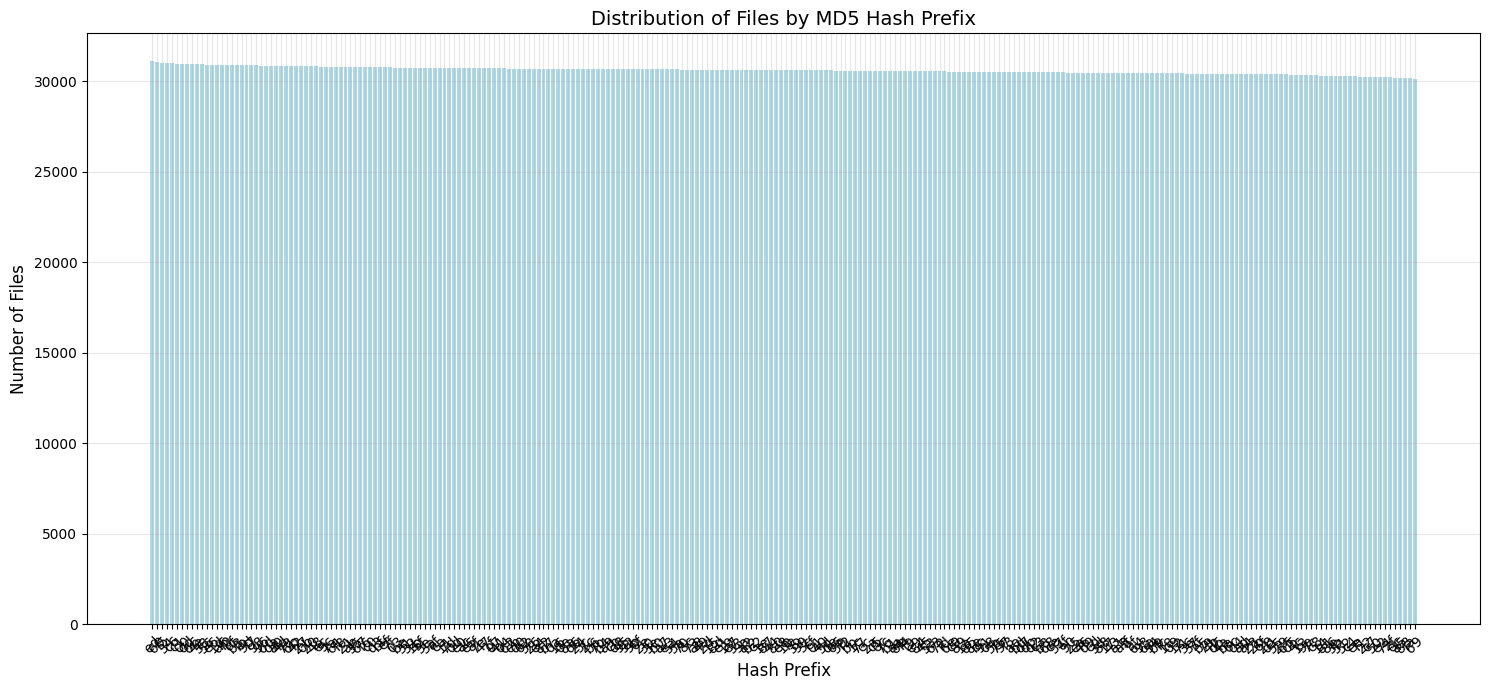


Summary Statistics:
Total number of files: 7,832,067
Total unique hashes: 7,832,067
Average file size: 0.49 MB
Total storage size: 3736.75 GB


In [34]:
import matplotlib.pyplot as plt

# SQL query to analyze MD5 hash patterns
query = """
SELECT 
    LEFT(metadata_md5, 2) as hash_prefix,
    COUNT(*) as hash_count,
    COUNT(DISTINCT metadata_md5) as unique_hashes,
    AVG(CAST(metadata_filesize AS BIGINT)) as avg_size,
    SUM(CAST(metadata_filesize AS BIGINT)) as total_size
FROM read_parquet('/data/aacF/aac_hathitrust_files*.parquet')
GROUP BY hash_prefix
ORDER BY hash_count DESC
"""

# Execute the query
result = con.execute(query).fetchdf()

# Convert sizes to MB and GB
result['avg_size_mb'] = result['avg_size'] / (1024 * 1024)
result['total_size_gb'] = result['total_size'] / (1024 * 1024 * 1024)

# Print the analysis results
print(f"Analysis of {len(result)} MD5 hash prefixes:")
print(result.head())

# Visualization 1: Distribution of files by hash prefix
plt.figure(figsize=(15, 7))
plt.bar(result['hash_prefix'], result['hash_count'], color='lightblue')
plt.title('Distribution of Files by MD5 Hash Prefix', fontsize=14)
plt.xlabel('Hash Prefix', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(f"Total number of files: {result['hash_count'].sum():,}")
print(f"Total unique hashes: {result['unique_hashes'].sum():,}")
print(f"Average file size: {result['avg_size_mb'].mean():.2f} MB")
print(f"Total storage size: {result['total_size_gb'].sum():.2f} GB")


# Internet Archive 2 Analysis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Retrieved 3024709 records


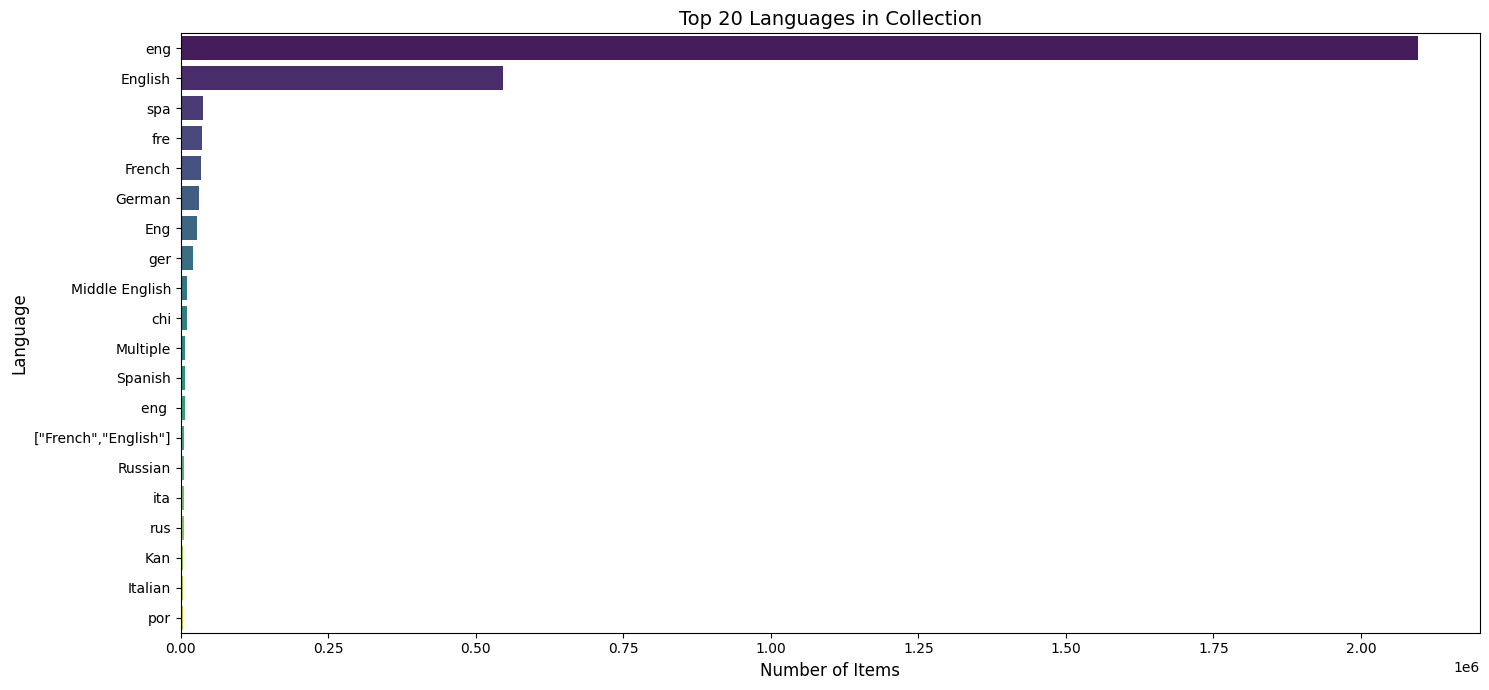

In [38]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# SQL query to analyze metadata
query = """
SELECT 
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.language') as language,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.mediatype') as mediatype,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.scanningcenter') as scanning_center,
    CAST(JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.imagecount') AS INTEGER) as image_count,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.date') as publication_date,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.publisher') as publisher
FROM read_parquet('/data/aacF/aac_ia2_records*.parquet')
WHERE metadata_metadata_json IS NOT NULL
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Display the first few rows of the result
print(f"Retrieved {len(result)} records")

# **Only Visualization**: Language distribution
plt.figure(figsize=(15, 7))
lang_counts = result['language'].value_counts().head(20)
sns.barplot(x=lang_counts.values, y=lang_counts.index, palette='viridis')
plt.title('Top 20 Languages in Collection', fontsize=14)
plt.xlabel('Number of Items', fontsize=12)
plt.ylabel('Language', fontsize=12)
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

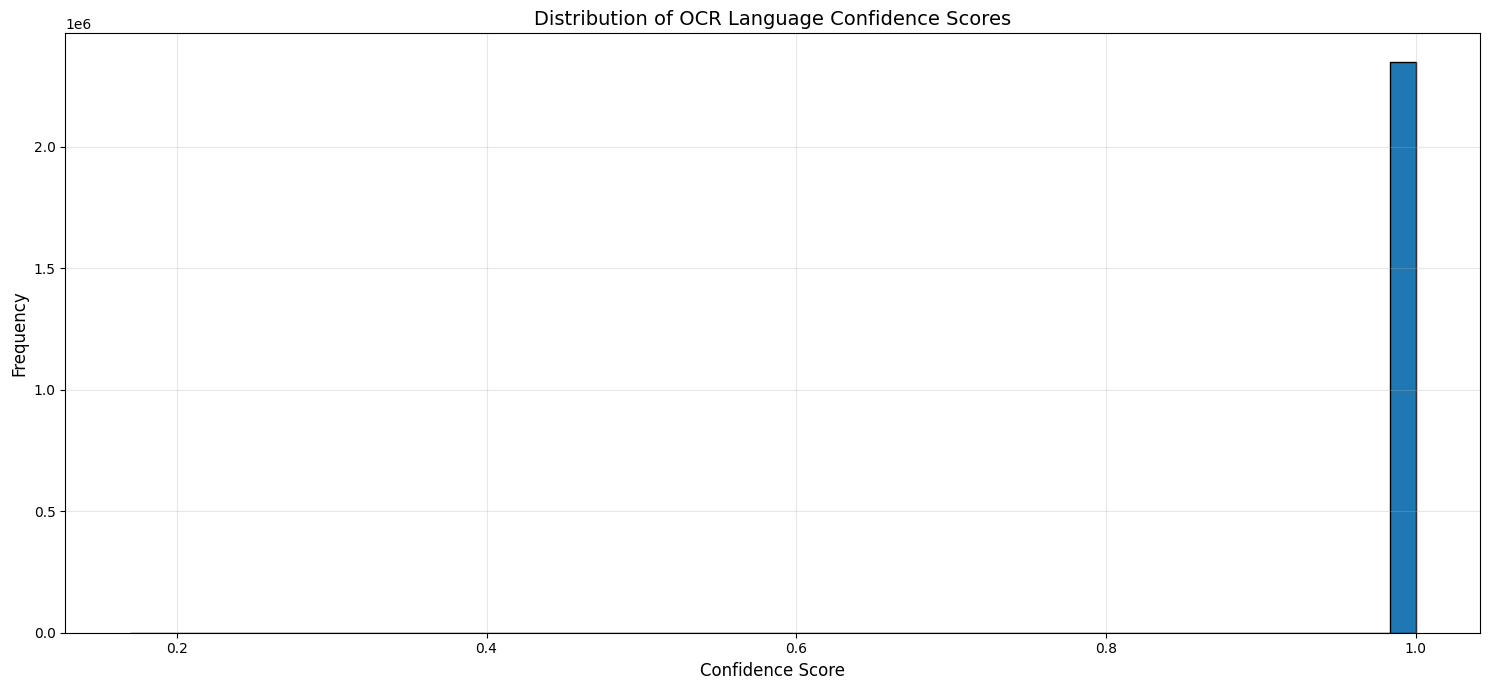


Summary Statistics:

OCR Confidence:
count    2.350101e+06
mean     9.998669e-01
std      6.737603e-03
min      1.695000e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: ocr_confidence, dtype: float64

Item Sizes (GB):
count     3023411.0
mean       0.603661
std        0.784186
min        0.000001
25%        0.215261
50%        0.453647
75%          0.7594
max      199.428187
Name: item_size_gb, dtype: Float64


In [39]:
import matplotlib.pyplot as plt

# SQL query to analyze OCR and technical metadata
query = """
SELECT 
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.ocr_detected_lang') as ocr_language,
    CAST(JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.ocr_detected_lang_conf') AS FLOAT) as ocr_confidence,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.scanner') as scanner,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.ppi') as ppi,
    JSON_EXTRACT_STRING(metadata_metadata_json, '$.metadata.camera') as camera,
    CAST(JSON_EXTRACT_STRING(metadata_metadata_json, '$.item_size') AS BIGINT) as item_size
FROM read_parquet('/data/aacF/aac_ia2_records*.parquet')
WHERE metadata_metadata_json IS NOT NULL
"""

# Execute the query
result = con.execute(query).fetchdf()

# Convert item size to GB for readability
result['item_size_gb'] = result['item_size'] / (1024**3)

# Visualization 1: OCR Language Confidence Distribution
plt.figure(figsize=(15, 7))
plt.hist(result['ocr_confidence'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of OCR Language Confidence Scores', fontsize=14)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print("\nOCR Confidence:")
print(result['ocr_confidence'].describe())
print("\nItem Sizes (GB):")
print(result['item_size_gb'].describe())


# ISBN Group Analysis

Analysis of 336 country-agency combinations:
                    country                      agency  registrant_count  \
0  United States of America               United States            566242   
1            United Kingdom  United Kingdom and Ireland            141403   
2                    France                      France            124893   
3                     Spain                       Spain            114154   
4                    Canada   Canada - English Language            107969   

   unique_registrants  unique_isbns  
0              566241        557563  
1              141403        130088  
2              124893        124018  
3              114154        114152  
4              107968         92161  


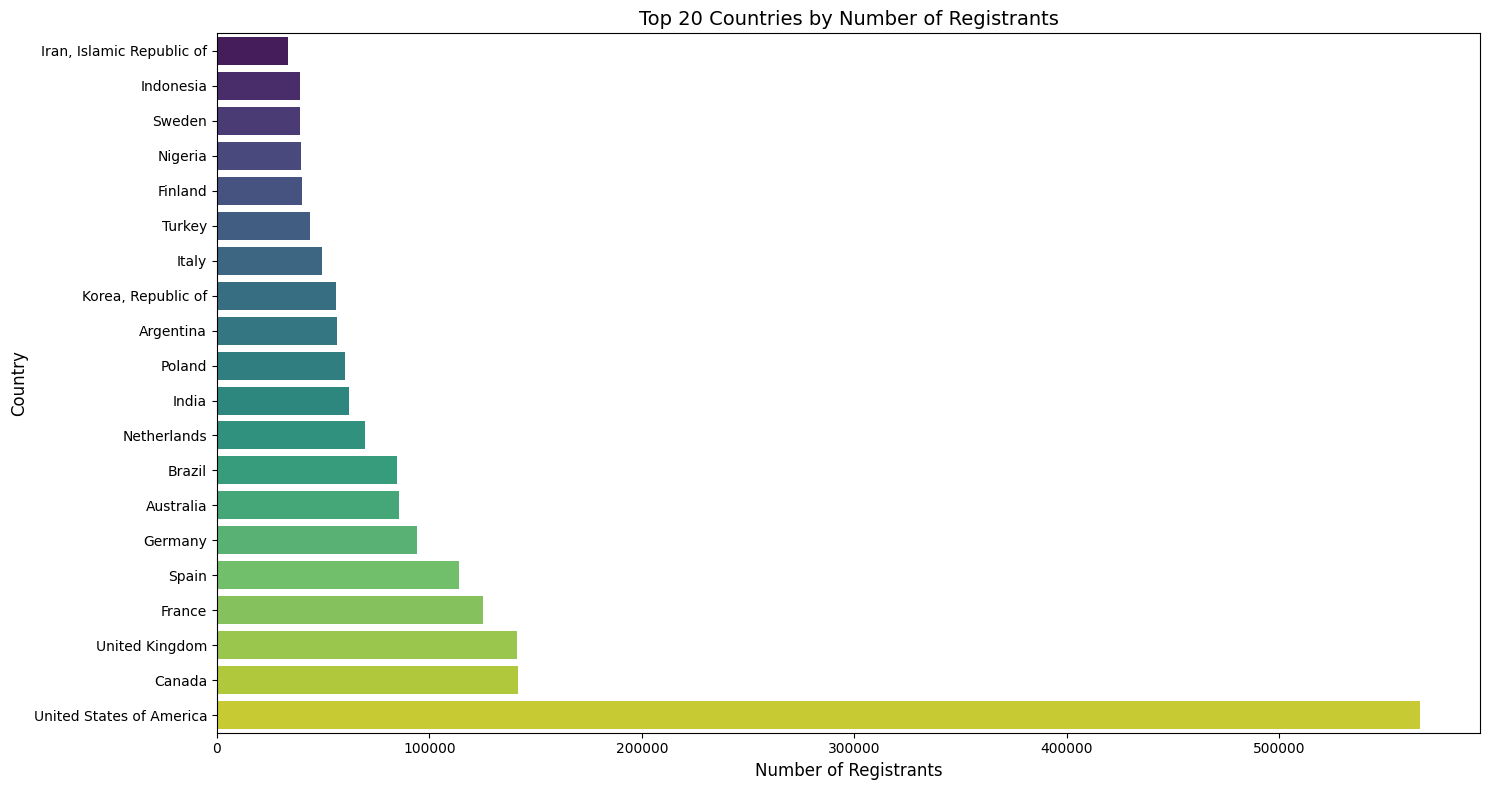


Summary Statistics:
Total number of countries: 229
Total number of agencies: 152
Total registrants: 2,744,530
Total unique ISBNs: 2,662,081


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# SQL query to analyze geographic and agency data
query = """
SELECT 
    metadata_record_country_name as country,
    metadata_record_agency_name as agency,
    COUNT(*) as registrant_count,
    COUNT(DISTINCT metadata_record_registrant_name) as unique_registrants,
    COUNT(DISTINCT metadata_record_isbns_0__isbn) as unique_isbns
FROM read_parquet('/data/aacF/aac_isbngrp_records*.parquet')
GROUP BY country, agency
ORDER BY registrant_count DESC
"""

# Execute the query and fetch the results
result = con.execute(query).fetchdf()

# Display the first few rows of the result
print(f"Analysis of {len(result)} country-agency combinations:")
print(result.head())

plt.figure(figsize=(15, 8))
top_countries = result.groupby('country')['registrant_count'].sum().sort_values(ascending=True).tail(20)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 20 Countries by Number of Registrants', fontsize=14)
plt.xlabel('Number of Registrants', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(f"Total number of countries: {result['country'].nunique():,}")
print(f"Total number of agencies: {result['agency'].nunique():,}")
print(f"Total registrants: {result['registrant_count'].sum():,}")
print(f"Total unique ISBNs: {result['unique_isbns'].sum():,}")


Analysis of 2716883 registrant-ISBN type combinations:
                          registrant isbn_type isbn_prefix  isbn_count
0  Author-publishers (miscellaneous)    prefix         978          77
1      Allocated, no current details    prefix         978          21
2      Allocated, no current details    isbn13         978          15
3                              Logos    prefix         978          15
4                            Papyrus    prefix         978          13


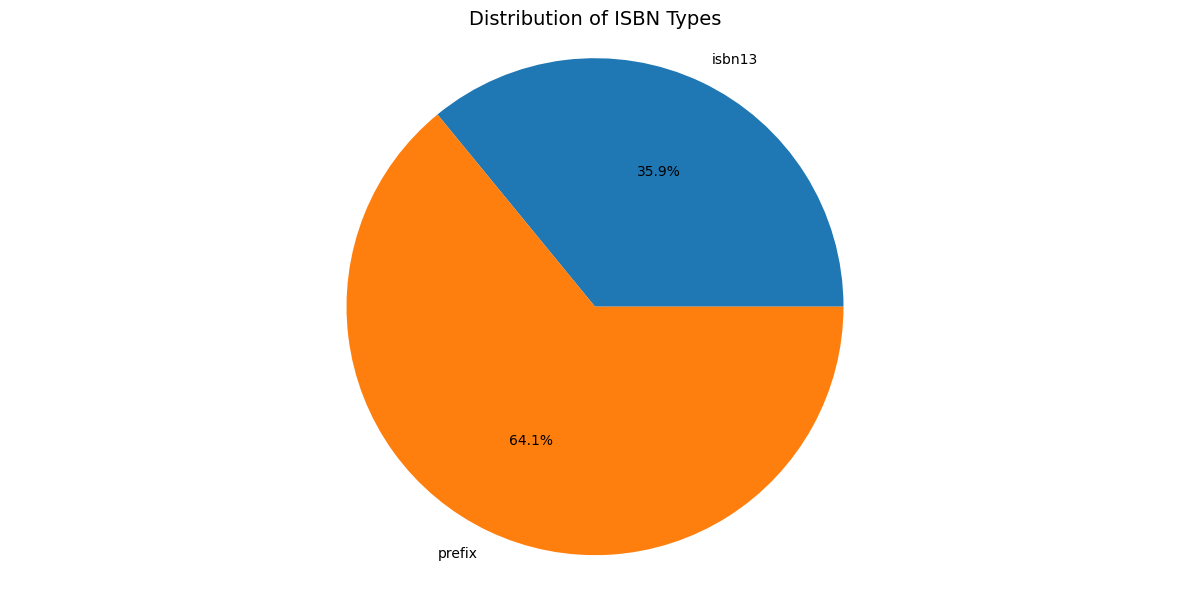


Detailed Statistics:

ISBN Type Distribution:
isbn_type
prefix    1758465
isbn13     986065
Name: isbn_count, dtype: int64


In [41]:
import matplotlib.pyplot as plt

# SQL query to analyze ISBN and registrant data
query = """
SELECT 
    metadata_record_registrant_name as registrant,
    metadata_record_isbns_0__isbn_type as isbn_type,
    LEFT(metadata_record_isbns_0__isbn, 3) as isbn_prefix,
    COUNT(*) as isbn_count
FROM read_parquet('/data/aacF/aac_isbngrp_records*.parquet')
GROUP BY registrant, isbn_type, isbn_prefix
ORDER BY isbn_count DESC
"""

# Execute the query
result = con.execute(query).fetchdf()

# Print analysis of results
print(f"Analysis of {len(result)} registrant-ISBN type combinations:")
print(result.head())

plt.figure(figsize=(12, 6))
isbn_type_counts = result.groupby('isbn_type')['isbn_count'].sum()
plt.pie(isbn_type_counts.values, labels=isbn_type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of ISBN Types', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Additional statistics
print("\nDetailed Statistics:")
print("\nISBN Type Distribution:")
print(result.groupby('isbn_type')['isbn_count'].sum().sort_values(ascending=False))


# Kulturpass Analysis

Retrieved 1607888 records


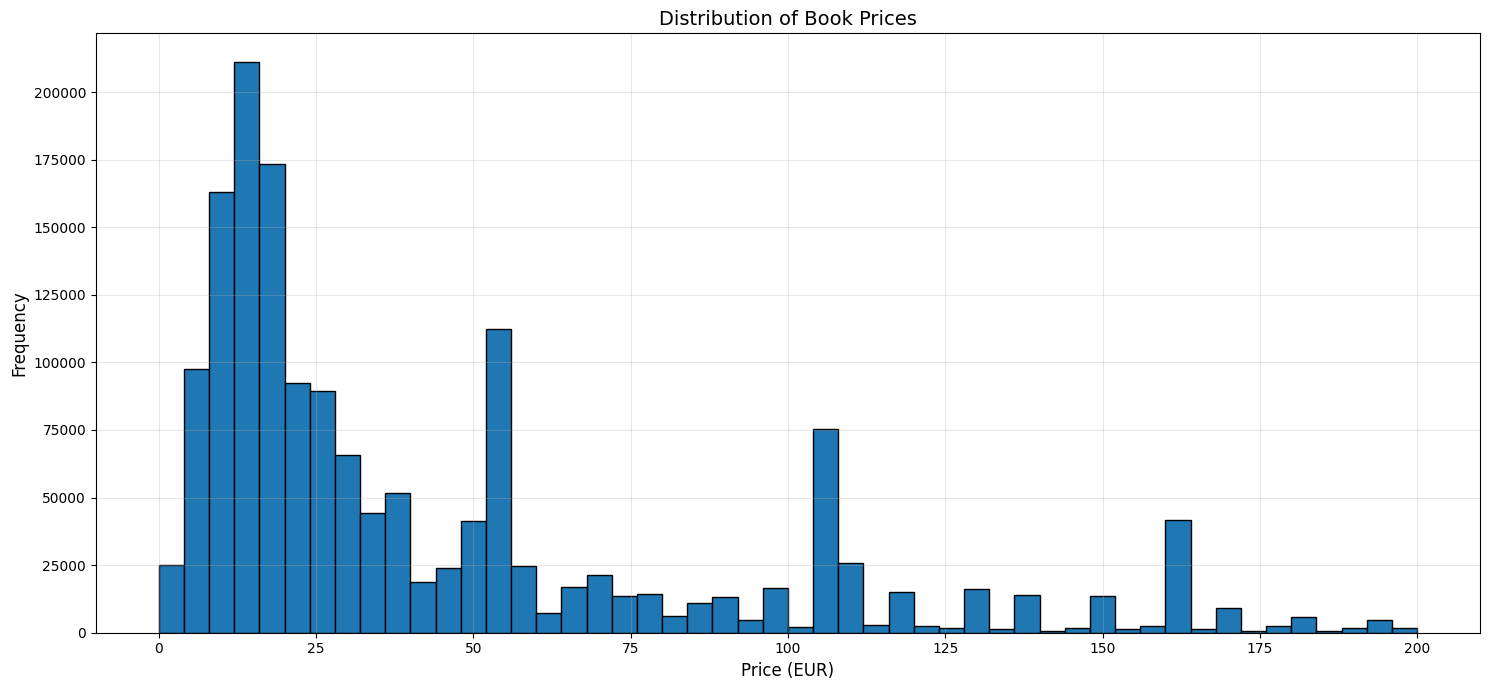


Price Statistics (EUR):
count    1.607888e+06
mean     4.489865e+01
std      4.377453e+01
min      0.000000e+00
25%      1.400000e+01
50%      2.499000e+01
75%      5.499000e+01
max      2.000000e+02
Name: price, dtype: float64


In [42]:
# Book and Price Analysis
query = """
SELECT 
    metadata_bookFormat as book_format,
    metadata_language as language,
    metadata_productType as product_type,
    metadata_publisher as publisher,
    CAST(metadata_offers_0__price_value AS FLOAT) as price,
    metadata_categories_0__name as category,
    metadata_purchasable as purchasable
FROM read_parquet('/data/aacF/aac_kulturpass_records*.parquet')
WHERE metadata_offers_0__price_value IS NOT NULL
"""

result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

plt.figure(figsize=(15, 7))
plt.hist(result['price'], bins=50, edgecolor='black')
plt.title('Distribution of Book Prices', fontsize=14)
plt.xlabel('Price (EUR)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Summary statistics
print("\nPrice Statistics (EUR):")
print(result['price'].describe())

Analysis of 501 shops:
                        shop_name                city postal_code   latitude  \
0  Buchstaeblich die Buchhandlung             Iphofen       97346  49.705181   
1  Fachbuchhandlung Gaby Schäfers                Köln       50668  50.954361   
2         Buchhandlung Dombrowsky          Regensburg       93047  49.017181   
3            Buchhandlung Volkert  Sulzbach-Rosenberg       92237  49.504330   
4   Historische Museen Reutlingen          Reutlingen       72764  48.492981   

   longitude wheelchair_accessible  book_count  avg_price  
0   10.26021                  true          93  19.556452  
1    6.96366                  None           1  15.000000  
2   12.09726                  true           6  30.000000  
3   11.74071                  None           3  20.000000  
4    9.20816                  true           1   7.000000  


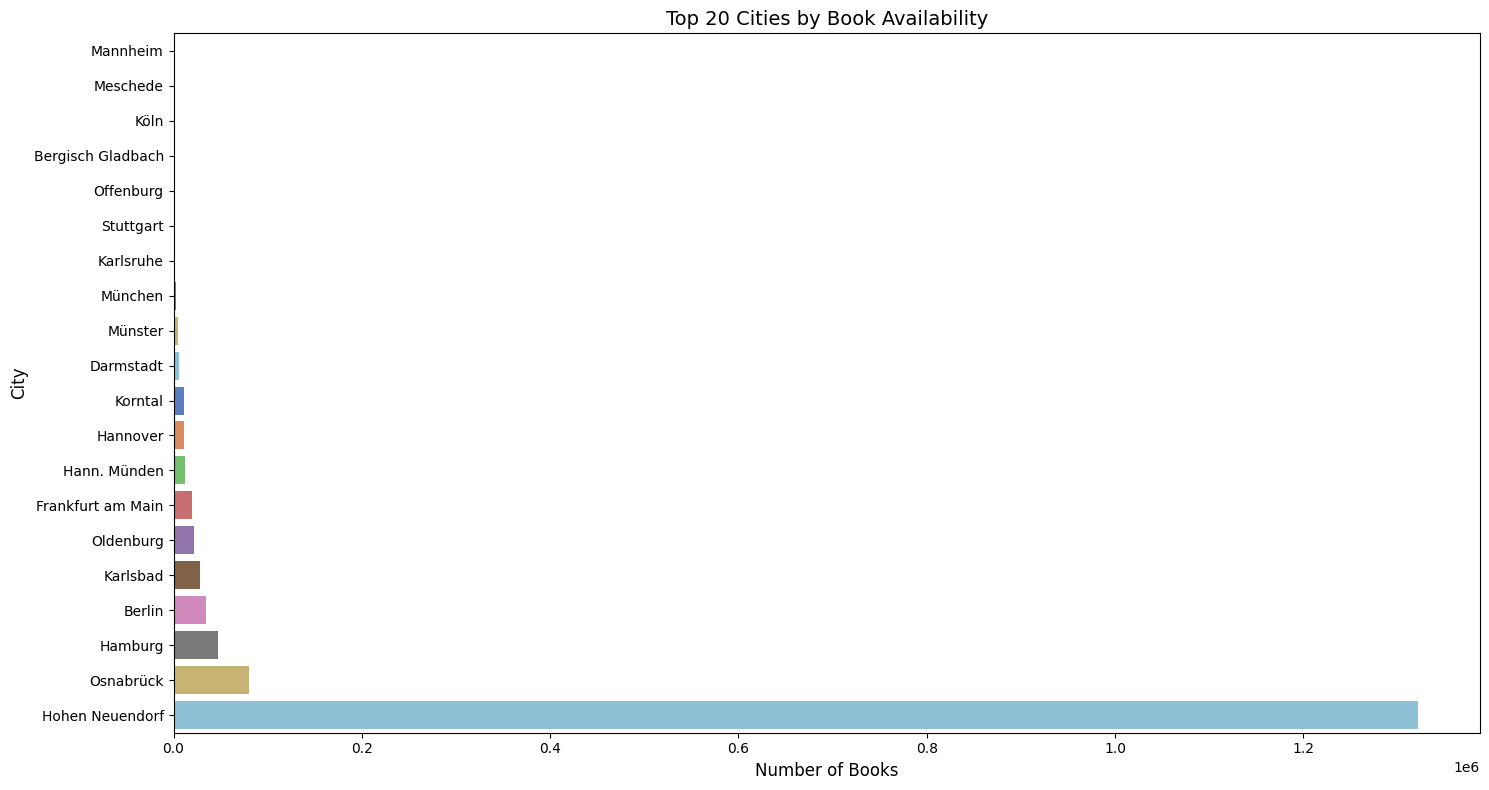

In [45]:
# Shop and Geographic Analysis
query = """
SELECT 
    metadata_offers_0__shopName as shop_name,
    metadata_offers_0__shopAddress_city as city,
    metadata_offers_0__shopAddress_postalCode as postal_code,
    CAST(metadata_offers_0__shopAddress_latitude AS FLOAT) as latitude,
    CAST(metadata_offers_0__shopAddress_longitude AS FLOAT) as longitude,
    metadata_offers_0__accessibilityWheelchairShop as wheelchair_accessible,
    COUNT(*) as book_count,
    AVG(CAST(metadata_offers_0__price_value AS FLOAT)) as avg_price
FROM read_parquet('/data/aacF/aac_kulturpass_records*.parquet')
WHERE metadata_offers_0__shopName IS NOT NULL
GROUP BY shop_name, city, postal_code, latitude, longitude, wheelchair_accessible
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} shops:")
print(result.head())

plt.figure(figsize=(15, 8))
city_counts = result.groupby('city')['book_count'].sum().sort_values(ascending=True).tail(20)
sns.barplot(x=city_counts.values, y=city_counts.index, palette='muted')
plt.title('Top 20 Cities by Book Availability', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()



# Libby Records Analysis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Retrieved 8475354 records


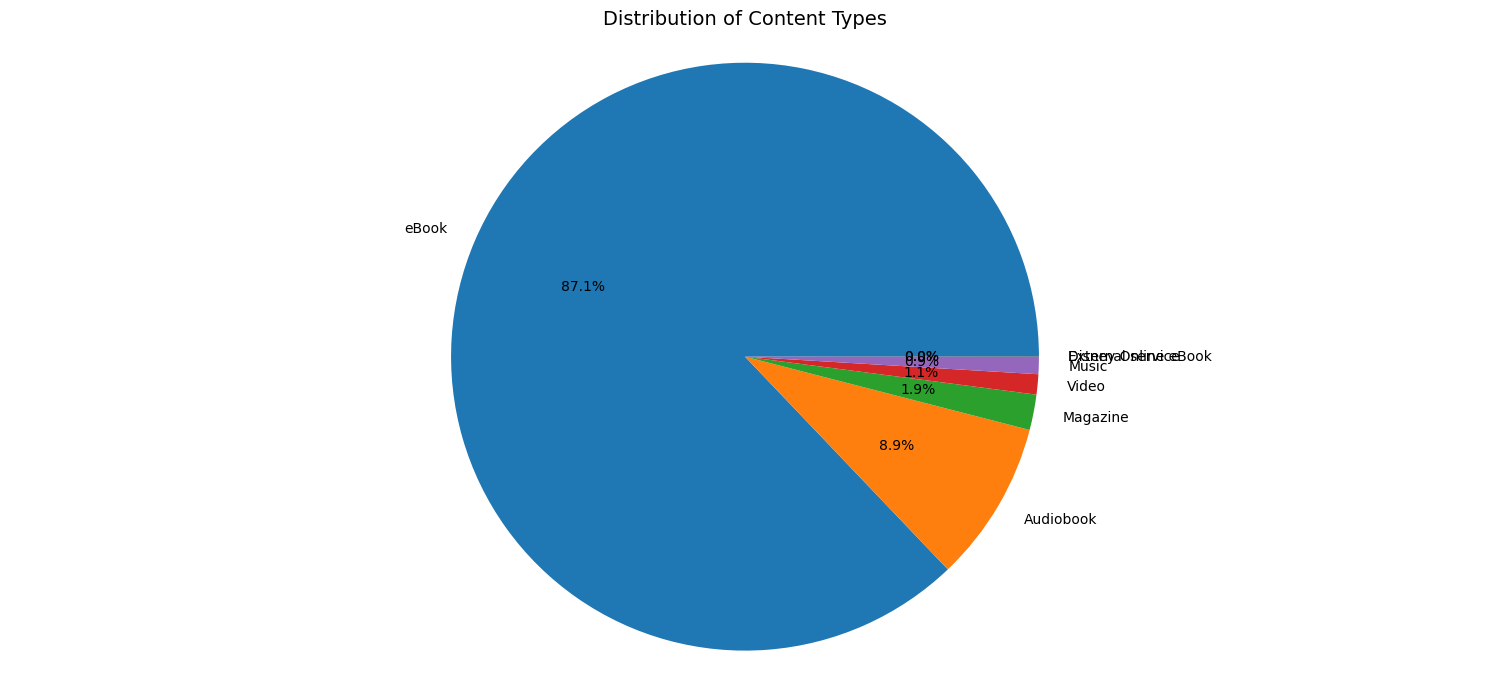

In [46]:
# Content and Publisher Analysis
query = """
SELECT 
    metadata_type_name as content_type,
    metadata_publisher_name as publisher,
    metadata_languages_0__name as language,
    metadata_ratings_maturityLevel_name as maturity_level,
    metadata_publishDate as publish_date,
    metadata_popularity as popularity,
    metadata_unitsSold as units_sold,
    metadata_juvenileEligible as juvenile_eligible,
    metadata_youngAdultEligible as young_adult_eligible,
    metadata_isPublicDomain as is_public_domain,
    metadata_bisac_0__description as bisac_category
FROM read_parquet('/data/aacF/aac_libby_records*.parquet')
"""

result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

plt.figure(figsize=(15, 7))
type_counts = result['content_type'].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Content Types', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


Analysis of 1930 format-subject combinations:
      format_name fulfillment_type has_audio_sync   content_rating  \
0  OverDrive Read          bifocal          false  General content   
1  OverDrive Read          bifocal          false  General content   
2     Kindle Book           kindle          false  General content   
3     Kindle Book           kindle          false  General content   
4  OverDrive Read          bifocal           true         Juvenile   

                     subject  unique_creators  avg_popularity  
0                    Fiction           334541        4.399250  
1                 Psychology            33078        2.970212  
2                 Technology             5532        1.205973  
3       Sports & Recreations             5674        6.952492  
4  Biography & Autobiography              362       52.258621  


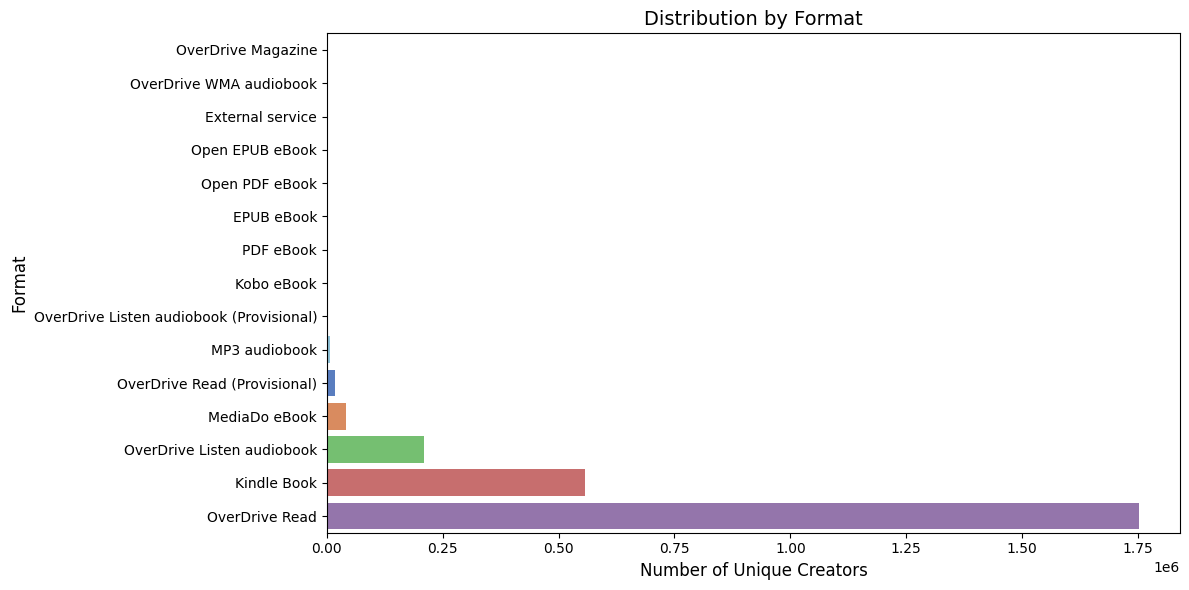


Summary Statistics:

Format Distribution:
format_name
OverDrive Read                              510
Kindle Book                                 352
OverDrive Listen audiobook                  252
OverDrive Read (Provisional)                139
MediaDo eBook                               122
MP3 audiobook                               110
OverDrive Listen audiobook (Provisional)     98
PDF eBook                                    95
EPUB eBook                                   89
Kobo eBook                                   85
OverDrive Magazine                           38
Open EPUB eBook                              21
Open PDF eBook                               15
OverDrive WMA audiobook                       3
External service                              1
dtype: int64

Fulfillment Types:
fulfillment_type
bifocal     800
kindle      352
media-do    122
odm         113
pdf         110
epub        110
kobo         85
ntc           1
Name: count, dtype: int64

Audio Sync Distribut

In [47]:
# Format and Rating Analysis
query = """
SELECT 
    metadata_formats_0__name as format_name,
    metadata_formats_0__fulfillmentType as fulfillment_type,
    metadata_formats_0__hasAudioSynchronizedText as has_audio_sync,
    metadata_ratings_naughtyScore_name as content_rating,
    metadata_subjects_0__name as subject,
    COUNT(DISTINCT metadata_creators_0__name) as unique_creators,
    AVG(CAST(metadata_popularity as FLOAT)) as avg_popularity
FROM read_parquet('/data/aacF/aac_libby_records*.parquet')
GROUP BY 
    format_name, 
    fulfillment_type, 
    has_audio_sync,
    content_rating,
    subject
HAVING format_name IS NOT NULL
"""

result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} format-subject combinations:")
print(result.head())

plt.figure(figsize=(12, 6))
format_counts = result.groupby('format_name')['unique_creators'].sum().sort_values(ascending=True)
sns.barplot(x=format_counts.values, y=format_counts.index, palette='muted')
plt.title('Distribution by Format', fontsize=14)
plt.xlabel('Number of Unique Creators', fontsize=12)
plt.ylabel('Format', fontsize=12)
plt.tight_layout()
plt.show()



# Summary statistics
print("\nSummary Statistics:")
print("\nFormat Distribution:")
print(result.groupby('format_name').size().sort_values(ascending=False))
print("\nFulfillment Types:")
print(result['fulfillment_type'].value_counts())
print("\nAudio Sync Distribution:")
print(result['has_audio_sync'].value_counts())

# Magazine Database Analysis

Retrieved 1798554 records


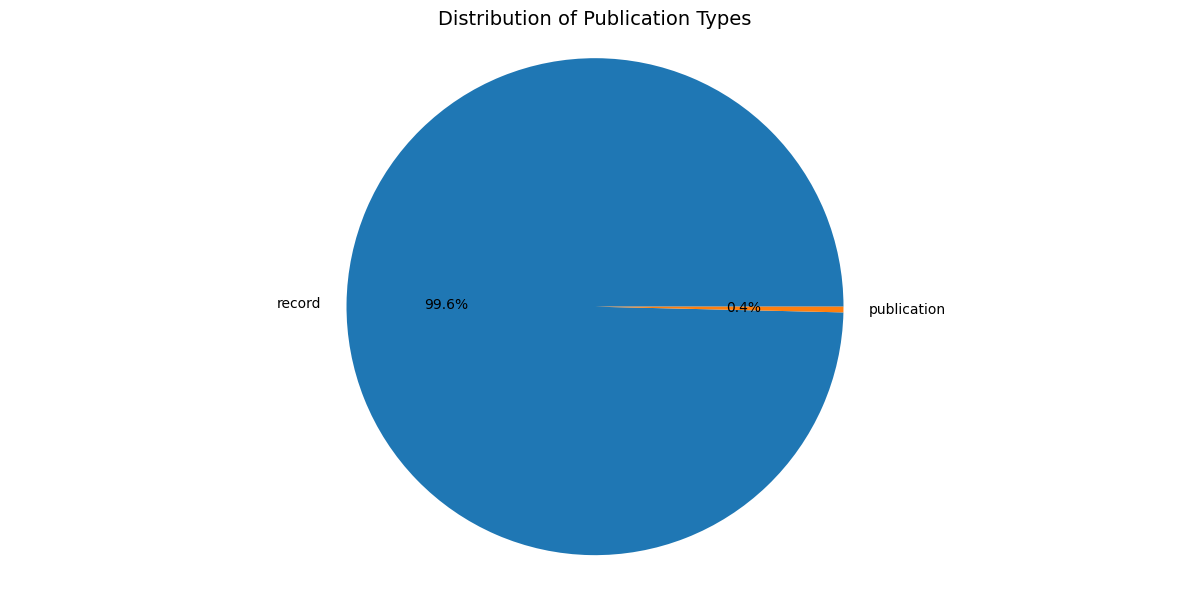

In [52]:
# Publication Analysis
query = """
SELECT 
    metadata_record_type as pub_type,
    metadata_record_year as year,
    metadata_record_edition as edition,
    metadata_record_publicationId as publication_id,
    metadata_record_uploads_0__format as format,  -- Correct column name
    metadata_record_uploads_0__contentType as content_type,
    CAST(metadata_record_uploads_0__sizeB AS BIGINT) as file_size
FROM read_parquet('/data/aacF/aac_magzdb_records*.parquet')
"""

# Execute the query
result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

# Visualization: Distribution of Publication Types
plt.figure(figsize=(12, 6))
type_counts = result['pub_type'].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Publication Types', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


Analysis of 401 uploader-content type combinations:
                      uploader    content_type  upload_count      avg_size  \
0                     Download            None         24687  4.604845e+07   
1                nekrasovka.ru            None          8720  1.211453e+07   
2  издательский оригинал-макет  Оригинал-макет          7032  1.920524e+07   
3                    +OCR слой        Скан+OCR          5537  1.958492e+07   
4                         РГДБ            None          3410  2.303119e+07   

   min_size   max_size  unique_publications  avg_size_mb  min_size_mb  \
0    147456  428608444                  298    43.915226     0.140625   
1   5474520   24172276                    1    11.553317     5.220909   
2     16044  247973294                  101    18.315542     0.015301   
3    699015  252235916                    9    18.677636     0.666633   
4  10713457   55799922                    2    21.964255    10.217149   

   max_size_mb  
0   408.752865  
1    2

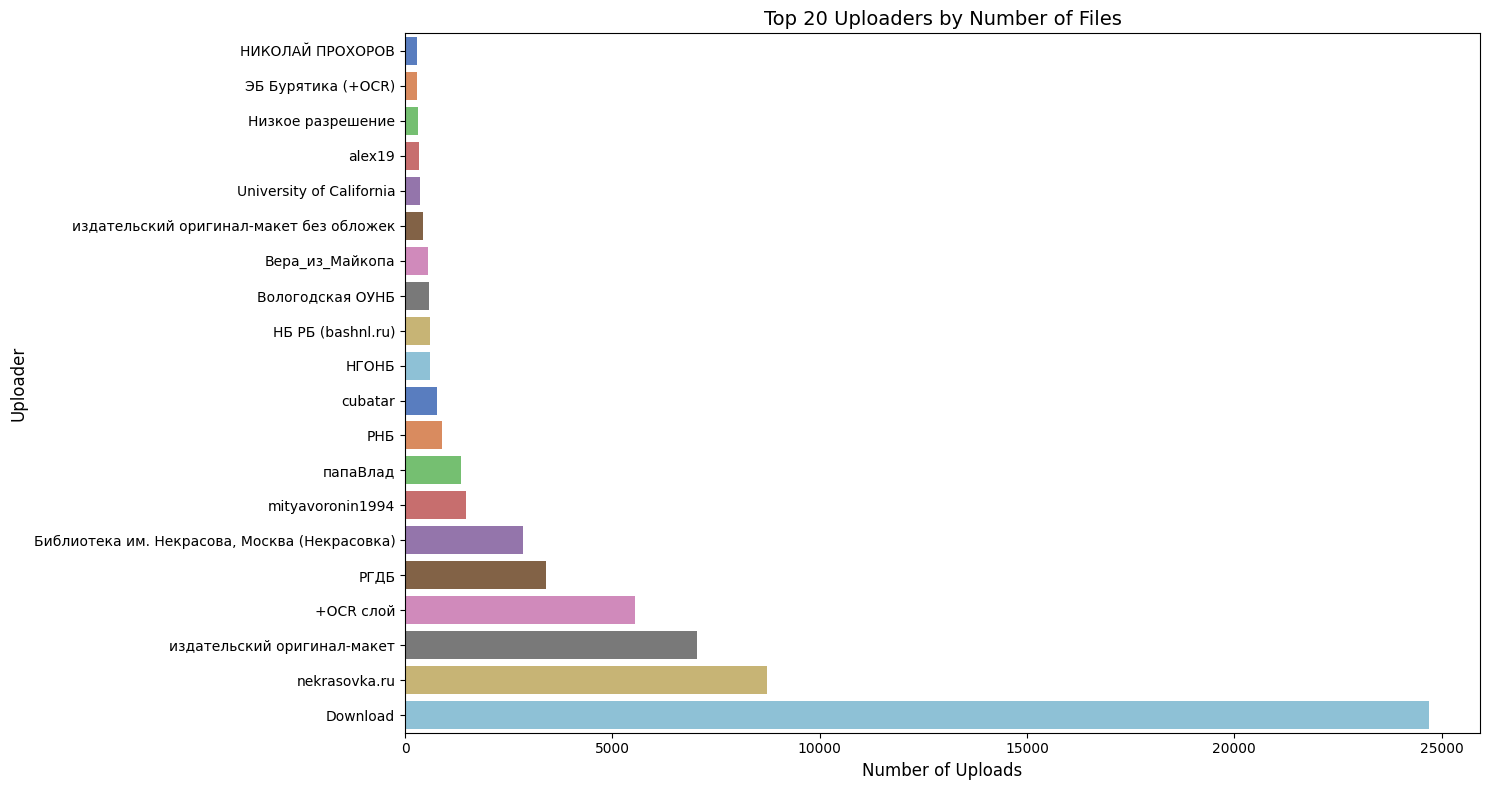


Summary Statistics:
Total unique uploaders: 383
Total unique content types: 5

Overall file size statistics (MB):
Average: 30.63
Minimum: 0.00
Maximum: 1970.67


In [57]:
# Upload and File Analysis
query = """
SELECT 
    metadata_record_uploads_0__author as uploader,
    metadata_record_uploads_0__contentType as content_type,
    COUNT(*) as upload_count,
    AVG(CAST(metadata_record_uploads_0__sizeB AS BIGINT)) as avg_size,
    MIN(CAST(metadata_record_uploads_0__sizeB AS BIGINT)) as min_size,
    MAX(CAST(metadata_record_uploads_0__sizeB AS BIGINT)) as max_size,
    COUNT(DISTINCT metadata_record_publicationId) as unique_publications
FROM read_parquet('/data/aacF/aac_magzdb_records*.parquet')
WHERE metadata_record_uploads_0__author IS NOT NULL
GROUP BY uploader, content_type
ORDER BY upload_count DESC
"""

# Execute the query
result = con.execute(query).fetchdf()

# Convert sizes to MB for better readability
result['avg_size_mb'] = result['avg_size'] / (1024 * 1024)
result['min_size_mb'] = result['min_size'] / (1024 * 1024)
result['max_size_mb'] = result['max_size'] / (1024 * 1024)

# Print analysis of results
print(f"Analysis of {len(result)} uploader-content type combinations:")
print(result.head())

# Visualization: Top 20 Uploaders by Number of Files
plt.figure(figsize=(15, 8))
top_uploaders = result.groupby('uploader')['upload_count'].sum().sort_values(ascending=True).tail(20)
sns.barplot(x=top_uploaders.values, y=top_uploaders.index, palette='muted')
plt.title('Top 20 Uploaders by Number of Files', fontsize=14)
plt.xlabel('Number of Uploads', fontsize=12)
plt.ylabel('Uploader', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(f"Total unique uploaders: {result['uploader'].nunique():,}")
print(f"Total unique content types: {result['content_type'].nunique():,}")
print("\nOverall file size statistics (MB):")
print(f"Average: {result['avg_size_mb'].mean():.2f}")
print(f"Minimum: {result['min_size_mb'].min():.2f}")
print(f"Maximum: {result['max_size_mb'].max():.2f}")


# Nexus STC Analysis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_293/2181167980.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result['pub_date'] = pd.to_datetime(result['publication_date'], errors='coerce')


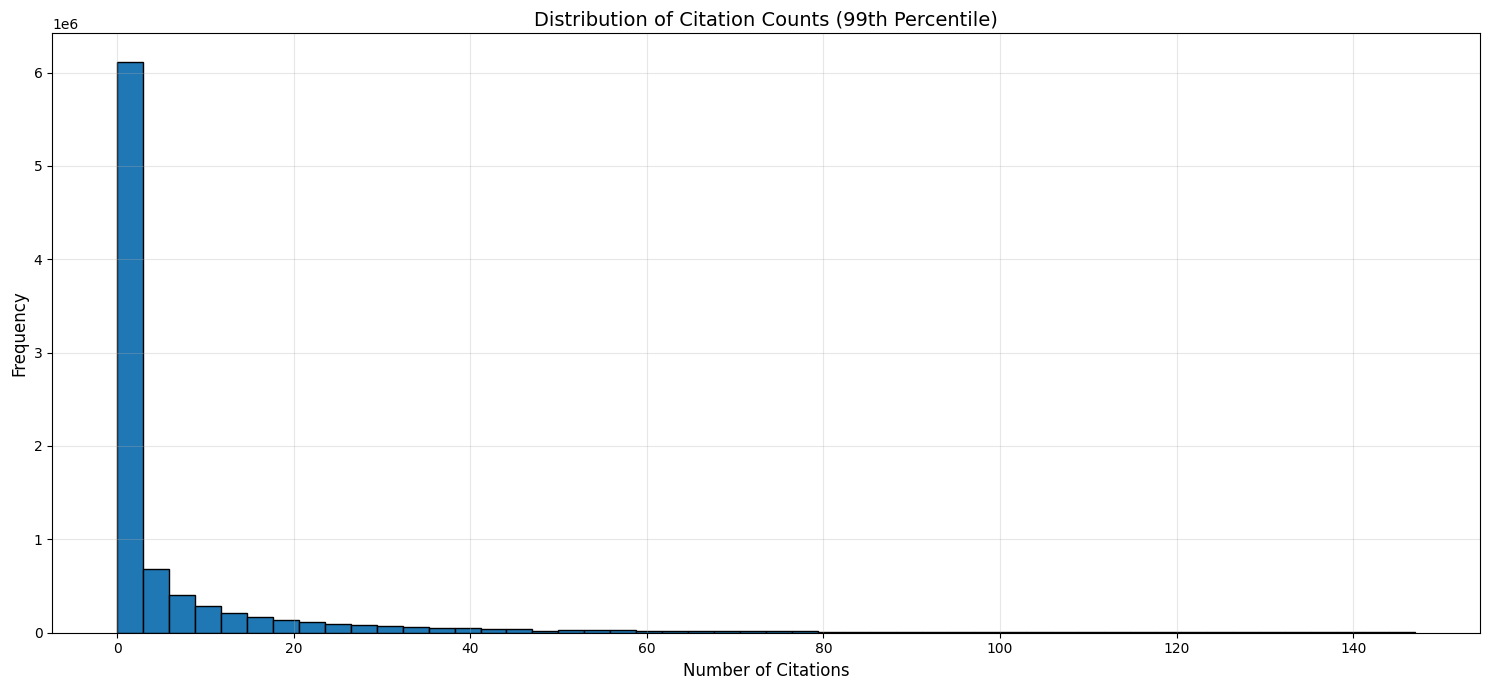

In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optimized DuckDB query with filters and a smaller result set to reduce RAM usage
query = """
SELECT 
    metadata_record_metadata_0__container_title AS journal,
    metadata_record_metadata_0__publisher AS publisher,
    metadata_record_type AS doc_type,
    metadata_record_languages AS languages,
    metadata_record_page_rank AS page_rank,
    metadata_record_referenced_by_count AS citation_count,
    metadata_record_custom_score AS custom_score,
    metadata_record_issued_at AS publication_date
FROM read_parquet('/data/aacF/aac_nexusstc_records*.parquet')
WHERE metadata_record_page_rank IS NOT NULL
  AND metadata_record_referenced_by_count IS NOT NULL
  AND metadata_record_custom_score IS NOT NULL
LIMIT 10000000 
"""

# Connect to DuckDB and execute the query
con = duckdb.connect()
result = con.execute(query).fetchdf()

# Apply transformations directly after retrieving the query results
result['page_rank'] = pd.to_numeric(result['page_rank'].str.strip('[]'), errors='coerce')
result['citation_count'] = pd.to_numeric(result['citation_count'].str.strip('[]'), errors='coerce')
result['custom_score'] = pd.to_numeric(result['custom_score'].str.strip('[]'), errors='coerce')

# Convert publication_date to datetime and extract the year
result['pub_date'] = pd.to_datetime(result['publication_date'], errors='coerce')
result['pub_year'] = result['pub_date'].dt.year

# Filter for citation counts below the 99th percentile
filtered_citation_count = result['citation_count'][result['citation_count'] < result['citation_count'].quantile(0.99)]

# Calculate histogram using numpy (faster than plt.hist)
counts, bin_edges = np.histogram(filtered_citation_count, bins=50)

# Create an optimized bar plot for the histogram
plt.figure(figsize=(15, 7))
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
plt.title('Distribution of Citation Counts (99th Percentile)', fontsize=14)
plt.xlabel('Number of Citations', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# WorldCat Analysis

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Retrieved 10000000 records


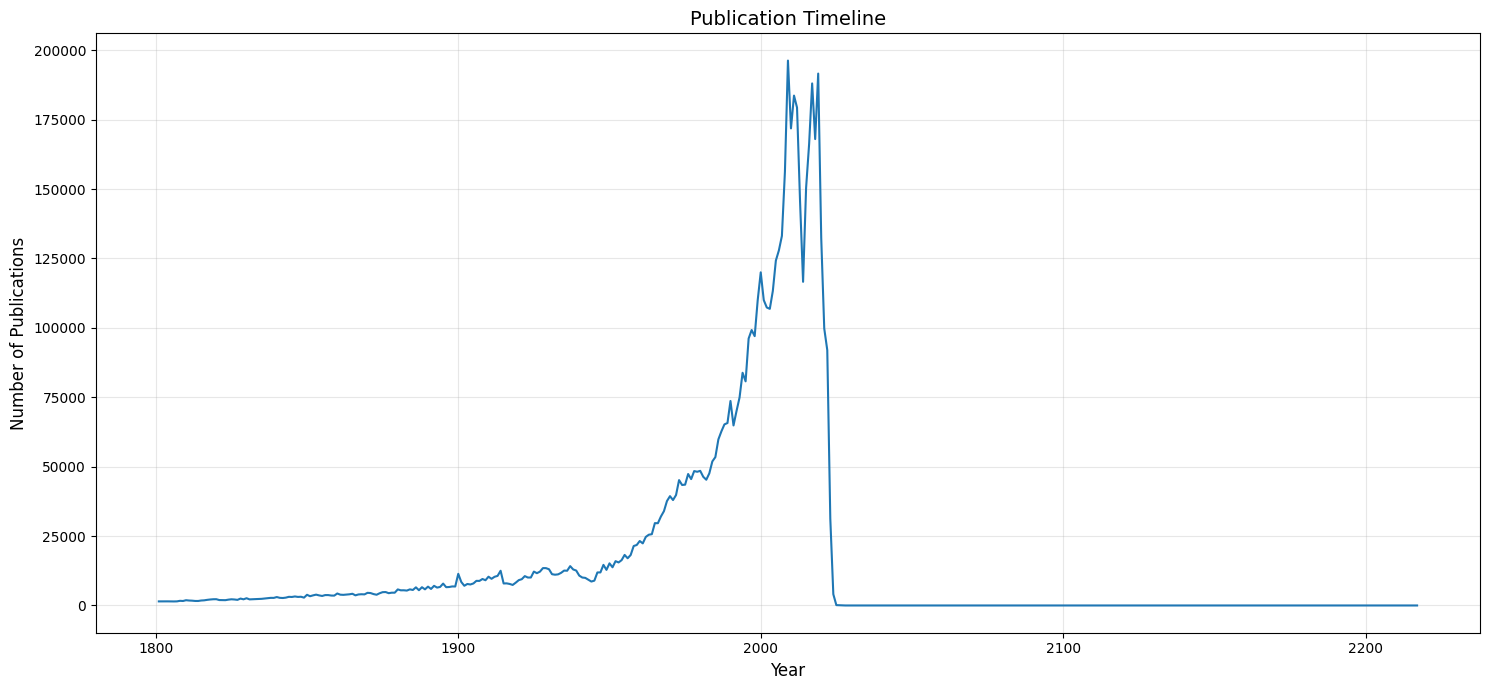

In [7]:
# Publication Analysis
query = """
SELECT 
    metadata_record_title as title,
    metadata_record_generalFormat as general_format,
    metadata_record_specificFormat as specific_format,
    metadata_record_publisher as publisher,
    metadata_record_publicationDate as publication_date,
    metadata_record_publicationPlace as publication_place,
    metadata_record_catalogingLanguage as language,
    CAST(metadata_record_totalEditions AS INTEGER) as total_editions,
    metadata_record_peerReviewed as is_peer_reviewed
FROM read_parquet('/data/aacF/aac_worldcat*.parquet')
WHERE metadata_record_title IS NOT NULL
LIMIT 10000000
"""

result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

# Create publication year from date 
result['pub_year'] = pd.to_datetime(result['publication_date'], errors='coerce').dt.year

plt.figure(figsize=(15, 7))
year_counts = result['pub_year'].value_counts().sort_index()
year_counts = year_counts[year_counts.index > 1800]  # Filter out very old years that might be errors
plt.plot(year_counts.index, year_counts.values)
plt.title('Publication Timeline', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_293/1462982585.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.values, y=language_counts.index, palette='muted')


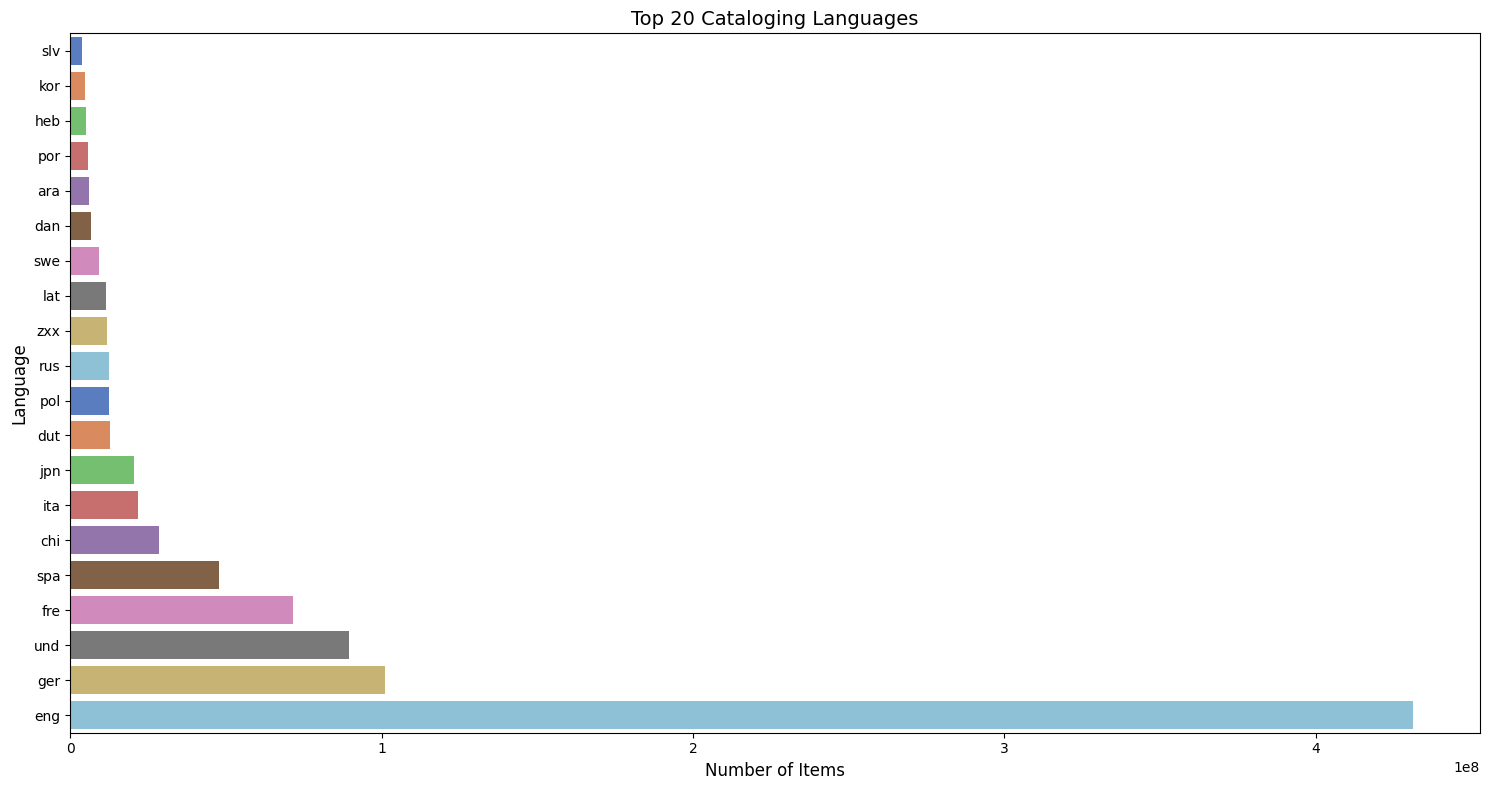


Summary Statistics:
Total items sampled: 2,086,373,058
Items with abstract: 10,051,358 (0.48%)
Items with ISBN: 1,269,541,358 (60.85%)
Items with primary contributor: 1,163,262,132 (55.76%)
Average editions per item: 1.55


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb

# Query to retrieve the data
query = """
SELECT 
    metadata_record_generalFormat as general_format,
    metadata_record_specificFormat as specific_format,
    metadata_record_catalogingLanguage as language,
    metadata_record_peerReviewed as is_peer_reviewed,
    metadata_type as metadata_type,
    COUNT(*) as item_count,
    COUNT(metadata_record_abstract) as with_abstract,
    COUNT(metadata_record_isbn13) as with_isbn,
    COUNT(metadata_record_contributors_0__isPrimary) as with_primary_contributor,
    AVG(CAST(metadata_record_totalEditions AS FLOAT)) as avg_editions
FROM read_parquet('/data/aacF/aac_worldcat*.parquet')
GROUP BY 
    metadata_record_generalFormat,
    metadata_record_specificFormat,
    metadata_record_catalogingLanguage,
    metadata_record_peerReviewed,
    metadata_type
ORDER BY item_count DESC
LIMIT 5000000
"""

# Connect to DuckDB and execute the query
con = duckdb.connect()
result = con.execute(query).fetchdf()

# Visualization of the top format-language combinations
plt.figure(figsize=(15, 8))
language_counts = result.groupby('language')['item_count'].sum().sort_values(ascending=True).tail(20)
sns.barplot(x=language_counts.values, y=language_counts.index, palette='muted')
plt.title('Top 20 Cataloging Languages', fontsize=14)
plt.xlabel('Number of Items', fontsize=12)
plt.ylabel('Language', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(f"Total items sampled: {result['item_count'].sum():,}")
print(f"Items with abstract: {result['with_abstract'].sum():,} ({result['with_abstract'].sum() / result['item_count'].sum() * 100:.2f}%)")
print(f"Items with ISBN: {result['with_isbn'].sum():,} ({result['with_isbn'].sum() / result['item_count'].sum() * 100:.2f}%)")
print(f"Items with primary contributor: {result['with_primary_contributor'].sum():,} ({result['with_primary_contributor'].sum() / result['item_count'].sum() * 100:.2f}%)")
print(f"Average editions per item: {result['avg_editions'].mean():.2f}")


# Z-Library Files Analysis

Retrieved 5512773 records

File Size Statistics (in MB) for valid files:
count: 3682140.00
mean: 6.91
std: 20.23
min: 0.00
25%: 0.42
50%: 1.05
75%: 3.91
max: 4997.21

Valid File Size Range (after filtering):
Min: 0.00019073486328125 MB
Max: 4997.214695930481 MB


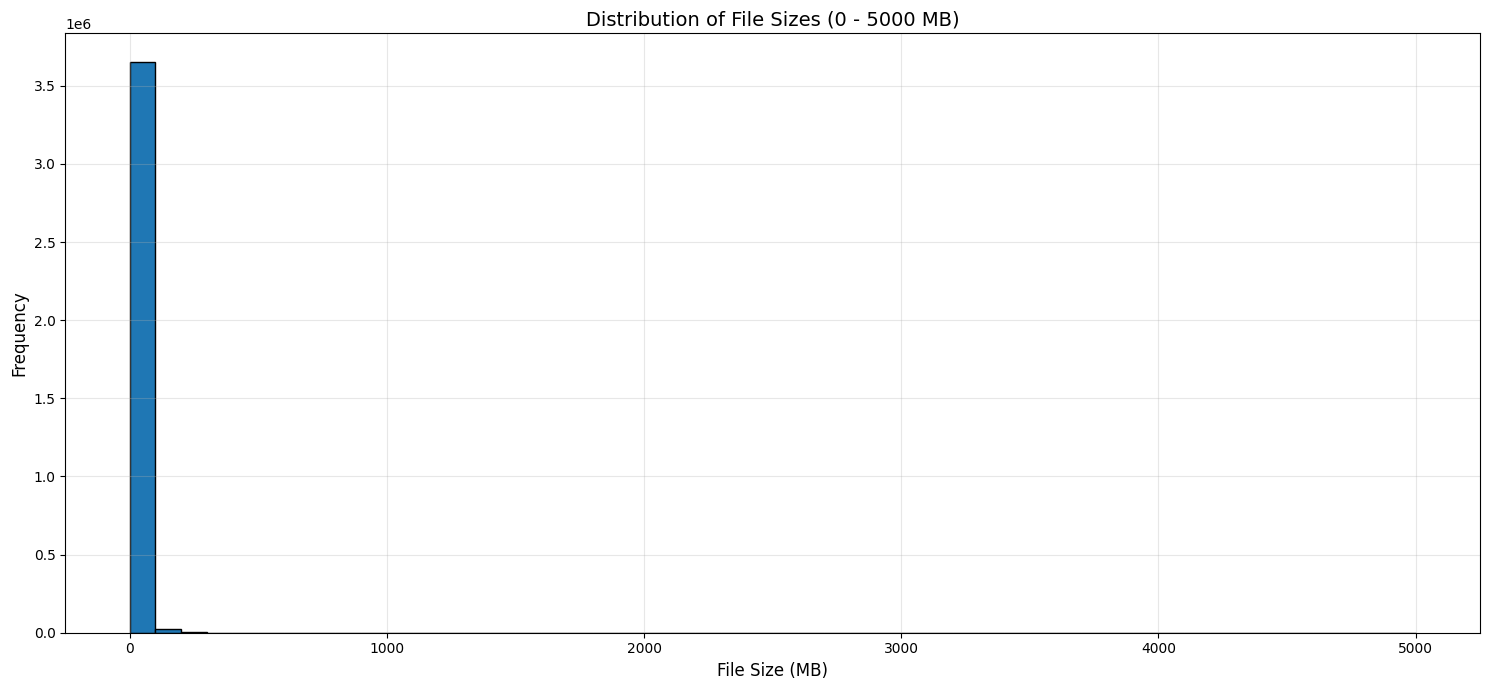


Records with missing file size: 1,830,633 (33.21%)


In [23]:
query = """
SELECT 
    metadata_md5 as md5,
    metadata_zlibrary_id as zlibrary_id,
    CAST(metadata_filesize AS BIGINT) as filesize
FROM read_parquet('/data/aacF/aac_zlib3_files*.parquet')
"""

# Execute the query and retrieve the results
result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

# Convert filesize to MB for files where size is available
result['filesize_mb'] = result['filesize'].fillna(0) / (1024 * 1024)

# Filter out invalid file sizes (close to 0 or missing data)
valid_files = result[result['filesize_mb'] > 0]

# Print the file size statistics of the valid data
print("\nFile Size Statistics (in MB) for valid files:")
size_stats = valid_files['filesize_mb'].describe()
for stat, value in size_stats.items():
    print(f"{stat}: {value:.2f}")

print("\nValid File Size Range (after filtering):")
print(f"Min: {valid_files['filesize_mb'].min()} MB")
print(f"Max: {valid_files['filesize_mb'].max()} MB")

plt.figure(figsize=(15, 7))
plt.hist(valid_files['filesize_mb'], bins=50, range=(0, 5000), edgecolor='black')  # Adjust range to cover up to 5000 MB
plt.title('Distribution of File Sizes (0 - 5000 MB)', fontsize=14)
plt.xlabel('File Size (MB)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Missing filesize information
missing_size = result['filesize'].isna().sum()
print(f"\nRecords with missing file size: {missing_size:,} ({missing_size/len(result)*100:.2f}%)")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Analysis of 5512773 data folders:


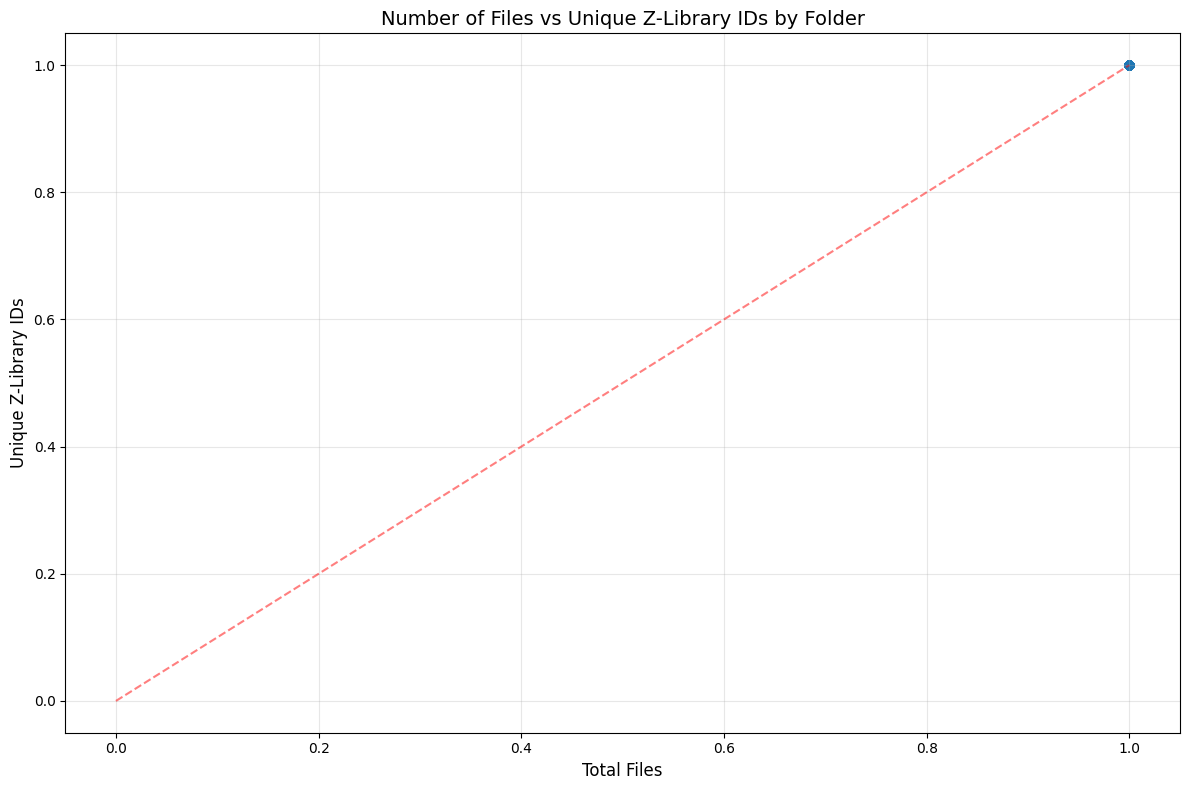


Overall Statistics:
Total files: 5,512,773
Unique Z-Library IDs: 5,512,773
Unique MD5 hashes: 5,512,773
Files with size information: 3,682,140.0 (66.79%)
Total storage size: 24852.79 GB
Average file size: 6.91 MB


In [26]:
query = """
WITH FolderStats AS (
    SELECT 
        metadata as folder,  -- Replace `data_folder` with `metadata`
        COUNT(*) as file_count,
        COUNT(DISTINCT metadata_zlibrary_id) as unique_zlibrary_ids,
        COUNT(DISTINCT metadata_md5) as unique_md5s,
        SUM(CASE WHEN metadata_filesize IS NOT NULL THEN 1 ELSE 0 END) as files_with_size,
        SUM(CAST(COALESCE(CAST(metadata_filesize AS BIGINT), 0) AS BIGINT)) as total_size,  -- Explicitly cast `metadata_filesize` to BIGINT
        AVG(CAST(metadata_filesize AS FLOAT)) as avg_size
    FROM read_parquet('/data/aacF/aac_zlib3_files*.parquet')
    GROUP BY metadata  -- Group by `metadata` or another available column
)
SELECT 
    *,
    files_with_size / CAST(file_count AS FLOAT) * 100 as pct_with_size,
    unique_zlibrary_ids / CAST(file_count AS FLOAT) * 100 as pct_unique_ids,
    total_size / (1024*1024*1024.0) as total_size_gb,
    avg_size / (1024*1024.0) as avg_size_mb
FROM FolderStats
ORDER BY file_count DESC
"""

# Execute the query and retrieve the results
result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} data folders:")

plt.figure(figsize=(12, 8))
plt.scatter(result['file_count'], result['unique_zlibrary_ids'], alpha=0.7)
plt.title('Number of Files vs Unique Z-Library IDs by Folder', fontsize=14)
plt.xlabel('Total Files', fontsize=12)
plt.ylabel('Unique Z-Library IDs', fontsize=12)
plt.grid(True, alpha=0.3)

# Add diagonal line for reference (perfect 1:1 ratio)
max_val = max(result['file_count'].max(), result['unique_zlibrary_ids'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nOverall Statistics:")
print(f"Total files: {result['file_count'].sum():,}")
print(f"Unique Z-Library IDs: {result['unique_zlibrary_ids'].sum():,}")
print(f"Unique MD5 hashes: {result['unique_md5s'].sum():,}")
print(f"Files with size information: {result['files_with_size'].sum():,} ({result['files_with_size'].sum() / result['file_count'].sum() * 100:.2f}%)")
print(f"Total storage size: {result['total_size_gb'].sum():.2f} GB")
print(f"Average file size: {result['avg_size_mb'].mean():.2f} MB")


# Z-Library Records Analysis

In [ ]:
query = """
SELECT 
    metadata_title as title,
    metadata_author as author,
    metadata_publisher as publisher,
    metadata_year as year,
    metadata_language as language,
    CAST(metadata_filesize_reported AS BIGINT) as filesize,
    metadata_extension as file_format,
    CASE 
        WHEN metadata_pages = '' THEN NULL
        ELSE CAST(metadata_pages AS INTEGER)
    END as page_count,  -- Handle empty strings and invalid values
    metadata_removed as is_removed,
    metadata_removalReason as removal_reason,
    metadata_isbns as isbn
FROM read_parquet('/data/aacF/aac_zlib3_records*.parquet')
WHERE metadata_title IS NOT NULL 
"""

# Execute the query and retrieve the results
result = con.execute(query).fetchdf()
print(f"Retrieved {len(result)} records")

# Convert filesize to MB
result['filesize_mb'] = result['filesize'] / (1024 * 1024)

# Convert year to numeric, handling errors
result['year_num'] = pd.to_numeric(result['year'], errors='coerce')

# Plotting the Publication Timeline
plt.figure(figsize=(15, 7))
year_counts = result['year_num'].value_counts().sort_index()
year_counts = year_counts[year_counts.index > 1800]  # Filter out very old years that might be errors
year_counts = year_counts[year_counts.index < 2023]  # Filter out future years
plt.plot(year_counts.index, year_counts.values)
plt.title('Publication Timeline', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Analysis of 73535 language-format-category combinations


/tmp/ipykernel_293/2937160904.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=format_size['avg_filesize_mb'], y=format_size.index, palette='muted')


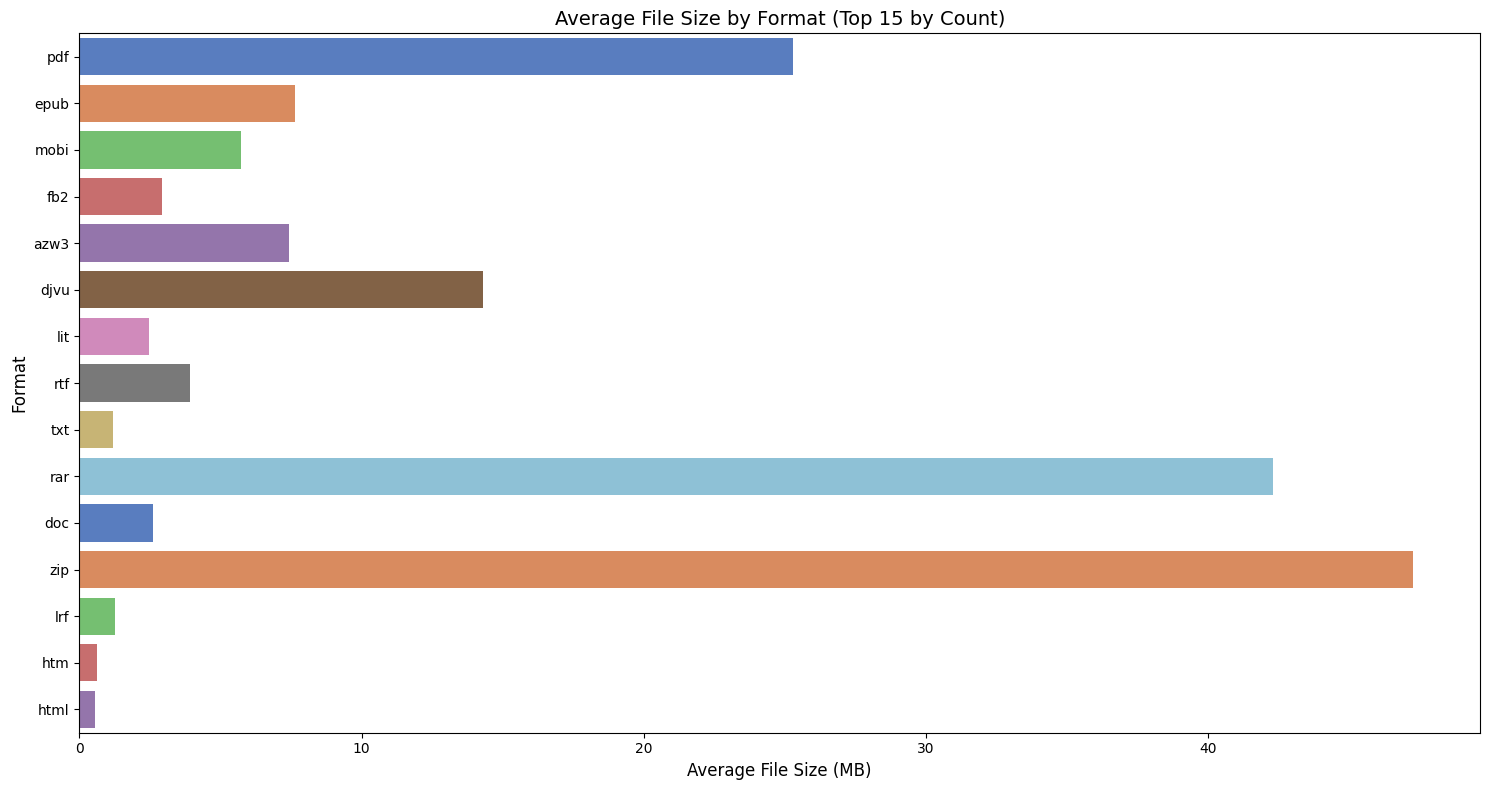

/tmp/ipykernel_293/2937160904.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')


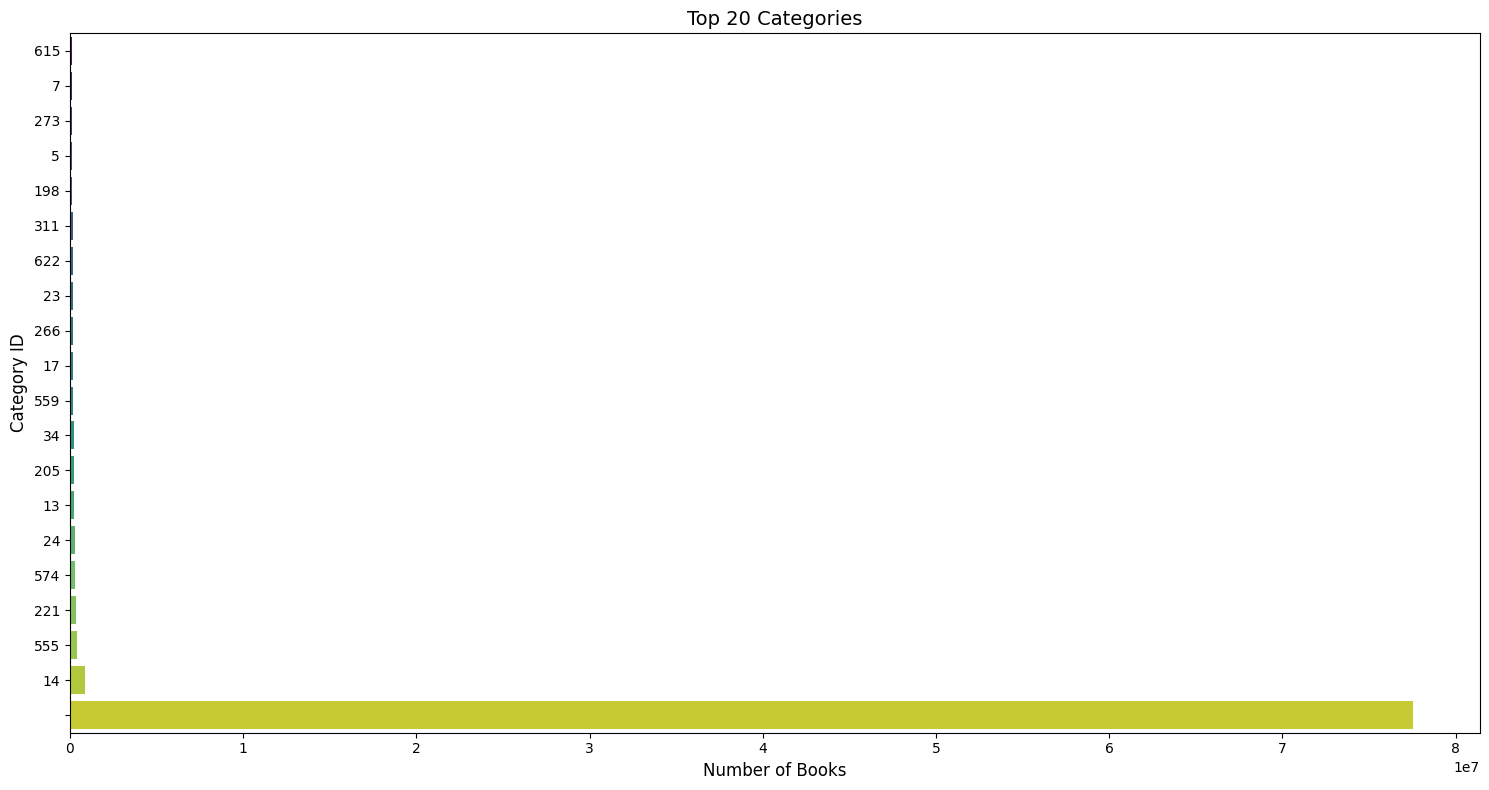

In [30]:
query = """
SELECT 
    metadata_language as language,
    metadata_extension as file_format,
    metadata_category_id as category_id,
    metadata_removed as is_removed,
    COUNT(*) as book_count,
    AVG(CAST(metadata_filesize_reported AS FLOAT)) as avg_filesize,
    AVG(CAST(NULLIF(metadata_pages, '') AS FLOAT)) as avg_pages,  -- Handle empty strings with NULLIF
    COUNT(DISTINCT metadata_publisher) as unique_publishers,
    MIN(metadata_year) as earliest_year,
    MAX(metadata_year) as latest_year,
    COUNT(DISTINCT metadata_zlibrary_id) as unique_ids
FROM read_parquet('/data/aacF/aac_zlib3_records*.parquet')
WHERE metadata_language IS NOT NULL
GROUP BY 
    metadata_language,
    metadata_extension,
    metadata_category_id,
    metadata_removed
ORDER BY book_count DESC
"""

# Execute the query and retrieve the results
result = con.execute(query).fetchdf()
print(f"Analysis of {len(result)} language-format-category combinations")

# Visualization for Average File Size by Format
plt.figure(figsize=(15, 8))
format_size = result.groupby('file_format').agg({
    'book_count': 'sum',
    'avg_filesize': 'mean'
}).sort_values('book_count', ascending=False).head(15)
format_size['avg_filesize_mb'] = format_size['avg_filesize'] / (1024 * 1024)

sns.barplot(x=format_size['avg_filesize_mb'], y=format_size.index, palette='muted')
plt.title('Average File Size by Format (Top 15 by Count)', fontsize=14)
plt.xlabel('Average File Size (MB)', fontsize=12)
plt.ylabel('Format', fontsize=12)
plt.tight_layout()
plt.show()

# Visualization for Top 20 Categories
plt.figure(figsize=(15, 8))
category_counts = result.groupby('category_id')['book_count'].sum().sort_values(ascending=True).tail(20)
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Top 20 Categories', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Category ID', fontsize=12)
plt.tight_layout()
plt.show()
